In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import time
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import os
import matplotlib.pyplot as plt
import time
import yaml
import pickle
import numpy as np
import csv 
import pandas as pd
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable

In [106]:
filename = "input_labels.csv"
X = []
y = []
with open(filename, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter='\n', quotechar='|')
    first = 0
    for row in spamreader:
      if first == 0:
        first = 1
        continue
      X.append(row[0].split(",")[0])
      y.append(row[0].split(",")[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
test_csv = "test_labels.csv"
train_csv = "train_labels.csv"
train_out = []
datapath = "data/"
for i in range(len(y_train)):
    if os.path.isfile(datapath+X_train[i]):
        train_out.append([X_train[i], y_train[i]])
with open(train_csv, 'w') as csvfile: 
    csvwriter = csv.writer(csvfile) 
    csvwriter.writerows(train_out)
test_out = []
for i in range(len(y_test)):
  if os.path.isfile(datapath+X_test[i]):
    test_out.append([X_test[i], y_test[i]])
with open(test_csv, 'w') as csvfile: 
    csvwriter = csv.writer(csvfile) 
    csvwriter.writerows(test_out)

In [107]:
class MalConv(nn.Module):
    # trained to minimize cross-entropy loss
    # criterion = nn.CrossEntropyLoss()
    def __init__(self, input_length=2000000, out_size=1, channels=128, window_size=512, embd_size=8, log_stride=None):
        super(MalConv, self).__init__()
        self.embd = nn.Embedding(257, embd_size, padding_idx=0)
        if not log_stride is None:
            stride = 2 ** log_stride
        self.window_size = window_size
    
        self.conv_1 = nn.Conv1d(embd_size, channels, window_size, stride=window_size, bias=True)
        self.conv_2 = nn.Conv1d(embd_size, channels, window_size, stride=window_size, bias=True)
        
        self.pooling = nn.MaxPool1d(int(input_length/window_size))
        
        self.fc_1 = nn.Linear(channels, channels)
        self.fc_2 = nn.Linear(channels, out_size)
      
    def processRange(self, x):
        x = self.embd(x)
        x = torch.transpose(x, -1, -2)

        cnn_value = self.conv_1(x)
        gating_weight = torch.sigmoid(self.conv_2(x))

        x = cnn_value * gating_weight

        return x
    
    def forward(self, x):
        
        x = self.embd(x.long())
        x = torch.transpose(x,-1,-2)
        
        cnn_value = self.conv_1(x)
        gating_weight = torch.sigmoid(self.conv_2(x))
        
        x = cnn_value * gating_weight
        
        x = self.pooling(x)
        
        #Flatten
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        x = F.sigmoid(x)
        
        return x

In [108]:
def getParams():
    # Format for this is to make it work easily with Optuna in an automated fashion.
    # variable name -> tuple(sampling function, dict(sampling_args) )
    params = {
        'channels': ("suggest_int", {'name': 'channels', 'low': 32, 'high': 1024}),
        'log_stride': ("suggest_int", {'name': 'log2_stride', 'low': 2, 'high': 9}),
        'window_size': ("suggest_int", {'name': 'window_size', 'low': 32, 'high': 512}),
        'embd_size': ("suggest_int", {'name': 'embd_size', 'low': 4, 'high': 64}),
    }
    return OrderedDict(sorted(params.items(), key=lambda t: t[0]))
    
def initModel(**kwargs):
    new_args = {}
    for x in getParams():
        if x in kwargs:
            new_args[x] = kwargs[x]

    return MalConv(**new_args)
  
def write_pred(test_pred,test_idx,file_path):
	test_pred = [item for sublist in test_pred for item in sublist]
	with open(file_path,'w') as f:
		for idx,pred in zip(test_idx,test_pred):
			print(idx.upper()+','+str(pred[0]),file=f)

class ExeDataset(Dataset):
	def __init__(self, fp_list, data_path, label_list, first_n_byte=2000000):
		self.fp_list = fp_list
		self.data_path = data_path
		self.label_list = label_list
		self.first_n_byte = first_n_byte

	def __len__(self):
		return len(self.fp_list)

	def __getitem__(self, idx):
		try:
			with open(self.data_path + self.fp_list[idx],'rb') as f:
				tmp = [i+1 for i in f.read()[:self.first_n_byte]] # index 0 will be special padding index 每个值加一
				tmp = tmp+[0]*(self.first_n_byte-len(tmp))
		except:
			with open(self.data_path + self.fp_list[idx].lower(),'rb') as f:
				tmp = [i+1 for i in f.read()[:self.first_n_byte]]
				tmp = tmp+[0]*(self.first_n_byte-len(tmp))

		return np.array(tmp), np.array([self.label_list[idx]])

In [109]:
config_path = "example.yaml" 
seed = 11
conf = yaml.safe_load(open(config_path,'r'))

exp_name = conf['exp_name']+'_sd_'+str(seed)
print('Experiment:')
print('\t',exp_name)

np.random.seed(seed)
torch.manual_seed(seed)

train_data_path = conf['train_data_path']
train_label_path = conf['train_label_path']

valid_data_path = conf['valid_data_path']
valid_label_path = conf['valid_label_path']

log_dir = conf['log_dir']
pred_dir = conf['pred_dir']
checkpoint_dir = conf['checkpoint_dir']


log_file_path = log_dir+exp_name+'.log'
chkpt_acc_path = checkpoint_dir+exp_name+'.model'
pred_path = pred_dir+exp_name+'.pred'

# Parameters
learning_rate = 0.0001
batch_size = 20
first_n_byte = 2000000
window_size = 500
use_gpu = conf['use_gpu']
use_cpu = conf['use_cpu']
max_step = conf['max_step']
test_step = conf['test_step']
display_step = conf['display_step']

sample_cnt = conf['sample_cnt']

# Load Ground Truth.
tr_label_table = pd.read_csv(train_label_path,header=None,index_col=0)
tr_label_table.index=tr_label_table.index.str.upper()
tr_label_table = tr_label_table.rename(columns={1:'ground_truth'})
val_label_table = pd.read_csv(valid_label_path,header=None,index_col=0)
val_label_table.index=val_label_table.index.str.upper()
val_label_table = val_label_table.rename(columns={1:'ground_truth'})

# Merge Tables and remove duplicate
tr_table = tr_label_table.groupby(level=0).last()
del tr_label_table
val_table = val_label_table.groupby(level=0).last()
del val_label_table
tr_table = tr_table.drop(val_table.index.join(tr_table.index, how='inner'))

print('Training Set:')
print('\tTotal',len(tr_table),'files')
print('\tMalware Count :',tr_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',tr_table['ground_truth'].value_counts()[0])


print('Validation Set:')
print('\tTotal',len(val_table),'files')
print('\tMalware Count :',val_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',val_table['ground_truth'].value_counts()[0])

if sample_cnt != 1:
    tr_table = tr_table.sample(n=sample_cnt,random_state=seed)

dataset_test = ExeDataset(list(tr_table.index), train_data_path, list(tr_table.ground_truth),first_n_byte)

start_train=time.perf_counter()
dataloader = DataLoader(dataset_test , batch_size=batch_size, shuffle=True, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_train = end_train-start_train
start_train=time.perf_counter()

validloader = DataLoader(ExeDataset(list(val_table.index), valid_data_path, list(val_table.ground_truth),first_n_byte),
                        batch_size=batch_size, shuffle=False, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_test = end_train-start_train

valid_idx = list(val_table.index)

malconv = MalConv(input_length=first_n_byte,window_size=window_size)
bce_loss = nn.BCEWithLogitsLoss()
adam_optim = optim.Adam([{'params':malconv.parameters()}],lr=learning_rate)
sigmoid = nn.Sigmoid()

if use_gpu:
    malconv = malconv.cuda()
    bce_loss = bce_loss.cuda()
    sigmoid = sigmoid.cuda()


step_msg = 'step-{}-loss-{:.6f}-acc-{:.4f}-time-{:.2f}'
valid_msg = 'step-{}-tr_loss-{:.6f}-tr_acc-{:.4f}-val_loss-{:.6f}-val_acc-{:.4f}'
log_msg = '{}, {:.6f}, {:.4f}, {:.6f}, {:.4f}, {:.2f}'
history = {}
history['val_loss'] = []
history['val_acc'] = []
history['val_pred'] = []
history['tr_loss'] = []
history['tr_acc'] = []
history['tr_time'] = []
history['val_time'] = []
history['enum_time'] = []

epoch_stats = {}
epoch_stats['val_loss'] = []
epoch_stats['val_acc'] = []
epoch_stats['val_pred'] = []
epoch_stats['tr_loss'] = []
epoch_stats['tr_acc'] = []
epoch_stats['tr_time'] = []
epoch_stats['val_time'] = []
epoch_stats['enum_time'] = []

log = open(log_file_path,'w')
log.write('step,tr_loss, tr_acc, val_loss, val_acc, time\n')

valid_best_acc = 0.0
total_step = 0
step_cost_time = 0

epoch = 0
max_epochs = 5
while epoch < max_epochs:
    print("EPOCH: "+ str(epoch))
    # Training 
    print("TRAINING:")
    start = time.perf_counter()
    for step,batch_data in enumerate(dataloader):
        end_enum = time.perf_counter()-start
        adam_optim.zero_grad()
        
        cur_batch_size = batch_data[0].size(0)

        exe_input = batch_data[0].cuda() if use_gpu else batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        
        label = batch_data[1].cuda() if use_gpu else batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        
        if (len(exe_input) <= 1):
          print(f"file too small: {len(exe_input)}")
          continue
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        loss.backward()
        history['tr_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['tr_acc'].append(batch_pred)
        step_cost_time = time.perf_counter()-start
        history['tr_time'].append(step_cost_time)
        history['enum_time'].append(end_enum)
        print("loss: " +str(np.mean(history['tr_loss'])) + " acc: " + str(np.mean(history['tr_acc'])) + " time: " + str(step_cost_time))
        adam_optim.step()
        start = time.perf_counter()
    
    print("VALIDATION:")
    start = time.perf_counter()
    for _,val_batch_data in enumerate(validloader):
        cur_batch_size = val_batch_data[0].size(0)
        exe_input = val_batch_data[0].cuda() if use_gpu else val_batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        label = val_batch_data[1].cuda() if use_gpu else val_batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        step_cost_time = time.perf_counter()-start
        history['val_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['val_acc'].append(batch_pred)
        history['val_pred'].append(list(pred.cpu().data.numpy()))
        history['val_time'].append(step_cost_time)
        print("loss: " +str(np.mean(history['val_loss'])) + " acc: " + str(np.mean(history['val_acc'])) + " time: " + str(step_cost_time))
        start = time.perf_counter()
    print(log_msg.format(total_step, np.mean(history['tr_loss']), np.mean(history['tr_acc']),
                    np.mean(history['val_loss']), np.mean(history['val_acc']),step_cost_time),
          file=log,flush=True)
    
    print(valid_msg.format(total_step,np.mean(history['tr_loss']),np.mean(history['tr_acc']),
                           np.mean(history['val_loss']),np.mean(history['val_acc'])))
    if valid_best_acc < np.mean(history['val_acc']):
        valid_best_acc = np.mean(history['val_acc'])
        torch.save(malconv,chkpt_acc_path)
        print('Checkpoint saved at',chkpt_acc_path)
        write_pred(history['val_pred'],valid_idx,pred_path)
        print('Prediction saved at', pred_path)
    epoch += 1
    epoch_stats['val_loss'].extend(history['val_loss'])
    epoch_stats['val_acc'].extend(history['val_acc'])
    epoch_stats['val_pred'].extend(history['val_pred'])
    epoch_stats['tr_loss'].extend(history['tr_loss'])
    epoch_stats['tr_acc'].extend(history['tr_acc'])
    epoch_stats['tr_time'].extend(history['tr_time'])
    epoch_stats['val_time'].extend(history['val_time'])
    epoch_stats['enum_time'].extend(history['enum_time'])
    history['val_loss'] = []
    history['val_acc'] = []
    history['val_pred'] = []
    history['tr_loss'] = []
    history['tr_acc'] = []
    history['tr_time'] = []
    history['val_time'] = []
    history['enum_time'] = []

Experiment:
	 example_sd_11
Training Set:
	Total 1335 files
	Malware Count : 387
	Goodware Count: 948
Validation Set:
	Total 236 files
	Malware Count : 64
	Goodware Count: 172
EPOCH: 0
TRAINING:
loss: 0.7949499 acc: 0.65 time: 4.587614205000136
loss: 0.823601 acc: 0.7250000000000001 time: 3.2079857110002195
loss: 0.8008426 acc: 0.6833333333333335 time: 3.0404968279999594
loss: 0.7933308 acc: 0.675 time: 3.3243642500001442
loss: 0.7835491 acc: 0.66 time: 3.268273338000654
loss: 0.78707266 acc: 0.6833333333333335 time: 3.124648659999366
loss: 0.7834945 acc: 0.6857142857142858 time: 3.4140387270017527
loss: 0.7790822 acc: 0.6875 time: 3.092384346000472
loss: 0.7768288 acc: 0.6944444444444444 time: 3.483733894001489
loss: 0.77064615 acc: 0.6849999999999999 time: 3.0859000770014973
loss: 0.7683365 acc: 0.6909090909090909 time: 3.34946306799975
loss: 0.76705176 acc: 0.7083333333333334 time: 2.860027660999549
loss: 0.7629331 acc: 0.7076923076923076 time: 3.073883635999664
loss: 0.7598273 acc:

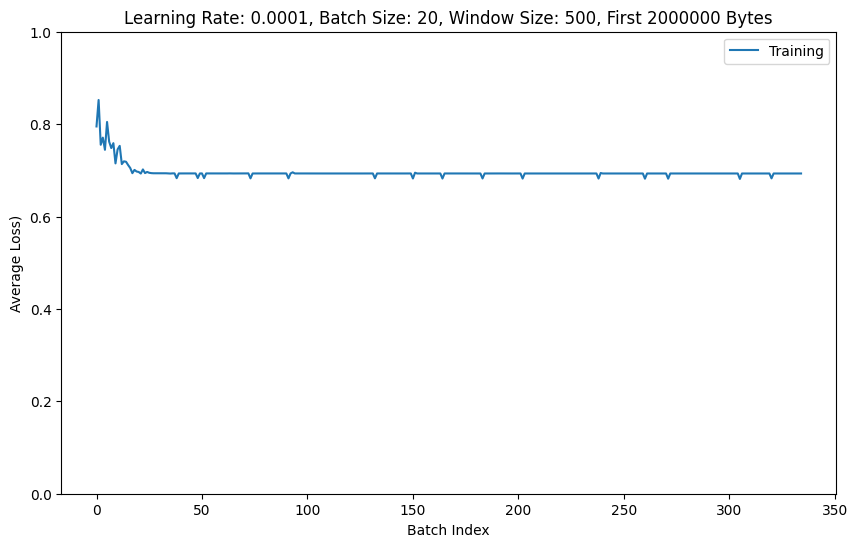

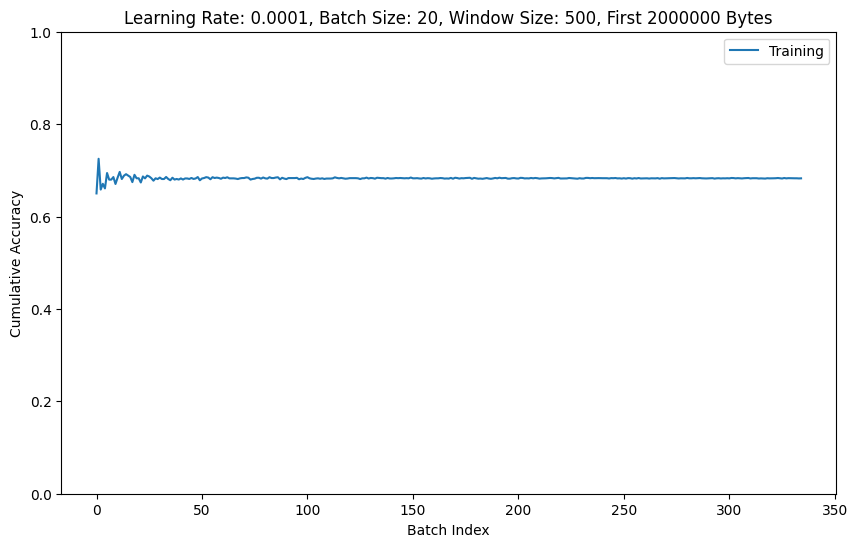

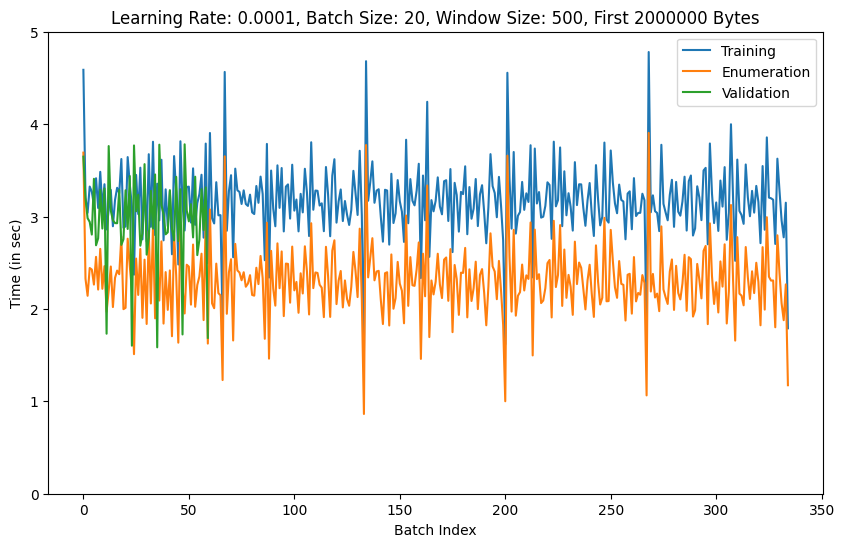

Training Dataloader Creation: 0.00031400599982589483
Validation Dataloader Creation: 0.00017931300135387573


In [110]:
x = range(len(epoch_stats['tr_loss']))

x2 = range(len(epoch_stats['val_loss']))
plt.figure(figsize=(10,6))
plt.plot(x,  epoch_stats['tr_loss'], label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Average Loss)")
plt.ylim([0, 1])
plt.legend()
plt.show()

cum_acc = []
for i in range(len(epoch_stats['tr_acc'])):
    cum_acc.append(np.mean(cum_acc + [epoch_stats['tr_acc'][i]]))
    
plt.figure(figsize=(10,6))
plt.plot(x,  cum_acc, label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Cumulative Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(x, epoch_stats['tr_time'], label = "Training")
plt.plot(x, epoch_stats['enum_time'], label = "Enumeration")
plt.plot(x2, epoch_stats['val_time'], label = "Validation")
plt.legend()
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Time (in sec)")
plt.ylim([0, 5])
plt.show()

print("Training Dataloader Creation: " + str(dataloader_create_train))
print("Validation Dataloader Creation: " + str(dataloader_create_test))

res_dict = {'cum_acc': cum_acc, 'val_time':epoch_stats['val_time'],'tr_time':epoch_stats['tr_time'], 'enum_time':epoch_stats['enum_time'], 'tr_loss':epoch_stats['tr_loss'], 'val_loss':epoch_stats['val_loss'],  'tr_acc':epoch_stats['tr_acc'],  'val_acc':epoch_stats['val_acc']}

with open('log/'+exp_name+'.pickle','wb') as handle:
	pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [111]:
# file = open("log/example_sd_11.pickle", "rb")
# try_dict = pickle.load(file)

In [112]:
config_path = "example.yaml" 
seed = 12
conf = yaml.safe_load(open(config_path,'r'))

exp_name = conf['exp_name']+'_sd_'+str(seed)
print('Experiment:')
print('\t',exp_name)

np.random.seed(seed)
torch.manual_seed(seed)

train_data_path = conf['train_data_path']
train_label_path = conf['train_label_path']

valid_data_path = conf['valid_data_path']
valid_label_path = conf['valid_label_path']

log_dir = conf['log_dir']
pred_dir = conf['pred_dir']
checkpoint_dir = conf['checkpoint_dir']


log_file_path = log_dir+exp_name+'.log'
chkpt_acc_path = checkpoint_dir+exp_name+'.model'
pred_path = pred_dir+exp_name+'.pred'

# Parameters
learning_rate = 0.0005
batch_size = 20
first_n_byte = 2000000
window_size = 500
use_gpu = conf['use_gpu']
use_cpu = conf['use_cpu']
max_step = conf['max_step']
test_step = conf['test_step']
display_step = conf['display_step']

sample_cnt = conf['sample_cnt']

# Load Ground Truth.
tr_label_table = pd.read_csv(train_label_path,header=None,index_col=0)
tr_label_table.index=tr_label_table.index.str.upper()
tr_label_table = tr_label_table.rename(columns={1:'ground_truth'})
val_label_table = pd.read_csv(valid_label_path,header=None,index_col=0)
val_label_table.index=val_label_table.index.str.upper()
val_label_table = val_label_table.rename(columns={1:'ground_truth'})

# Merge Tables and remove duplicate
tr_table = tr_label_table.groupby(level=0).last()
del tr_label_table
val_table = val_label_table.groupby(level=0).last()
del val_label_table
tr_table = tr_table.drop(val_table.index.join(tr_table.index, how='inner'))

print('Training Set:')
print('\tTotal',len(tr_table),'files')
print('\tMalware Count :',tr_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',tr_table['ground_truth'].value_counts()[0])


print('Validation Set:')
print('\tTotal',len(val_table),'files')
print('\tMalware Count :',val_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',val_table['ground_truth'].value_counts()[0])

if sample_cnt != 1:
    tr_table = tr_table.sample(n=sample_cnt,random_state=seed)

dataset_test = ExeDataset(list(tr_table.index), train_data_path, list(tr_table.ground_truth),first_n_byte)

start_train=time.perf_counter()
dataloader = DataLoader(dataset_test , batch_size=batch_size, shuffle=True, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_train = end_train-start_train
start_train=time.perf_counter()

validloader = DataLoader(ExeDataset(list(val_table.index), valid_data_path, list(val_table.ground_truth),first_n_byte),
                        batch_size=batch_size, shuffle=False, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_test = end_train-start_train

valid_idx = list(val_table.index)

malconv = MalConv(input_length=first_n_byte,window_size=window_size)
bce_loss = nn.BCEWithLogitsLoss()
adam_optim = optim.Adam([{'params':malconv.parameters()}],lr=learning_rate)
sigmoid = nn.Sigmoid()

if use_gpu:
    malconv = malconv.cuda()
    bce_loss = bce_loss.cuda()
    sigmoid = sigmoid.cuda()


step_msg = 'step-{}-loss-{:.6f}-acc-{:.4f}-time-{:.2f}'
valid_msg = 'step-{}-tr_loss-{:.6f}-tr_acc-{:.4f}-val_loss-{:.6f}-val_acc-{:.4f}'
log_msg = '{}, {:.6f}, {:.4f}, {:.6f}, {:.4f}, {:.2f}'
history = {}
history['val_loss'] = []
history['val_acc'] = []
history['val_pred'] = []
history['tr_loss'] = []
history['tr_acc'] = []
history['tr_time'] = []
history['val_time'] = []
history['enum_time'] = []

epoch_stats = {}
epoch_stats['val_loss'] = []
epoch_stats['val_acc'] = []
epoch_stats['val_pred'] = []
epoch_stats['tr_loss'] = []
epoch_stats['tr_acc'] = []
epoch_stats['tr_time'] = []
epoch_stats['val_time'] = []
epoch_stats['enum_time'] = []

log = open(log_file_path,'w')
log.write('step,tr_loss, tr_acc, val_loss, val_acc, time\n')

valid_best_acc = 0.0
total_step = 0
step_cost_time = 0

epoch = 0
max_epochs = 5
while epoch < max_epochs:
    print("EPOCH: "+ str(epoch))
    # Training 
    print("TRAINING:")
    start = time.perf_counter()
    for step,batch_data in enumerate(dataloader):
        end_enum = time.perf_counter()-start
        adam_optim.zero_grad()
        
        cur_batch_size = batch_data[0].size(0)

        exe_input = batch_data[0].cuda() if use_gpu else batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        
        label = batch_data[1].cuda() if use_gpu else batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        
        if (len(exe_input) <= 1):
          print(f"file too small: {len(exe_input)}")
          continue
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        loss.backward()
        history['tr_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['tr_acc'].append(batch_pred)
        step_cost_time = time.perf_counter()-start
        history['tr_time'].append(step_cost_time)
        history['enum_time'].append(end_enum)
        print("loss: " +str(np.mean(history['tr_loss'])) + " acc: " + str(np.mean(history['tr_acc'])) + " time: " + str(step_cost_time))
        adam_optim.step()
        start = time.perf_counter()
    
    print("VALIDATION:")
    start = time.perf_counter()
    for _,val_batch_data in enumerate(validloader):
        cur_batch_size = val_batch_data[0].size(0)
        exe_input = val_batch_data[0].cuda() if use_gpu else val_batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        label = val_batch_data[1].cuda() if use_gpu else val_batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        step_cost_time = time.perf_counter()-start
        history['val_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['val_acc'].append(batch_pred)
        history['val_pred'].append(list(pred.cpu().data.numpy()))
        history['val_time'].append(step_cost_time)
        print("loss: " +str(np.mean(history['val_loss'])) + " acc: " + str(np.mean(history['val_acc'])) + " time: " + str(step_cost_time))
        start = time.perf_counter()
    print(log_msg.format(total_step, np.mean(history['tr_loss']), np.mean(history['tr_acc']),
                    np.mean(history['val_loss']), np.mean(history['val_acc']),step_cost_time),
          file=log,flush=True)
    
    print(valid_msg.format(total_step,np.mean(history['tr_loss']),np.mean(history['tr_acc']),
                           np.mean(history['val_loss']),np.mean(history['val_acc'])))
    if valid_best_acc < np.mean(history['val_acc']):
        valid_best_acc = np.mean(history['val_acc'])
        torch.save(malconv,chkpt_acc_path)
        print('Checkpoint saved at',chkpt_acc_path)
        write_pred(history['val_pred'],valid_idx,pred_path)
        print('Prediction saved at', pred_path)
    epoch += 1
    epoch_stats['val_loss'].extend(history['val_loss'])
    epoch_stats['val_acc'].extend(history['val_acc'])
    epoch_stats['val_pred'].extend(history['val_pred'])
    epoch_stats['tr_loss'].extend(history['tr_loss'])
    epoch_stats['tr_acc'].extend(history['tr_acc'])
    epoch_stats['tr_time'].extend(history['tr_time'])
    epoch_stats['val_time'].extend(history['val_time'])
    epoch_stats['enum_time'].extend(history['enum_time'])
    history['val_loss'] = []
    history['val_acc'] = []
    history['val_pred'] = []
    history['tr_loss'] = []
    history['tr_acc'] = []
    history['tr_time'] = []
    history['val_time'] = []
    history['enum_time'] = []

Experiment:
	 example_sd_12
Training Set:
	Total 1335 files
	Malware Count : 387
	Goodware Count: 948
Validation Set:
	Total 236 files
	Malware Count : 64
	Goodware Count: 172
EPOCH: 0
TRAINING:
loss: 0.895856 acc: 0.8 time: 4.7381287930002145
loss: 0.85348874 acc: 0.775 time: 2.9592562779998843
loss: 0.8241408 acc: 0.75 time: 3.9842455879988847
loss: 0.80845296 acc: 0.775 time: 2.155642387999251
loss: 0.787856 acc: 0.75 time: 3.3327928060007252
loss: 0.7724025 acc: 0.725 time: 3.4758081259988103
loss: 0.7613254 acc: 0.7142857142857143 time: 2.925681204000284
loss: 0.7528814 acc: 0.7062499999999999 time: 3.219841660999009
loss: 0.7462563 acc: 0.6833333333333332 time: 3.400838563000434
loss: 0.74095523 acc: 0.6749999999999999 time: 3.135824753000634
loss: 0.7366192 acc: 0.7 time: 3.566592560000572
loss: 0.7329989 acc: 0.6999999999999998 time: 2.8494392070006143
loss: 0.7299336 acc: 0.6923076923076922 time: 3.06282836399987
loss: 0.7273063 acc: 0.6892857142857142 time: 2.943247903000156


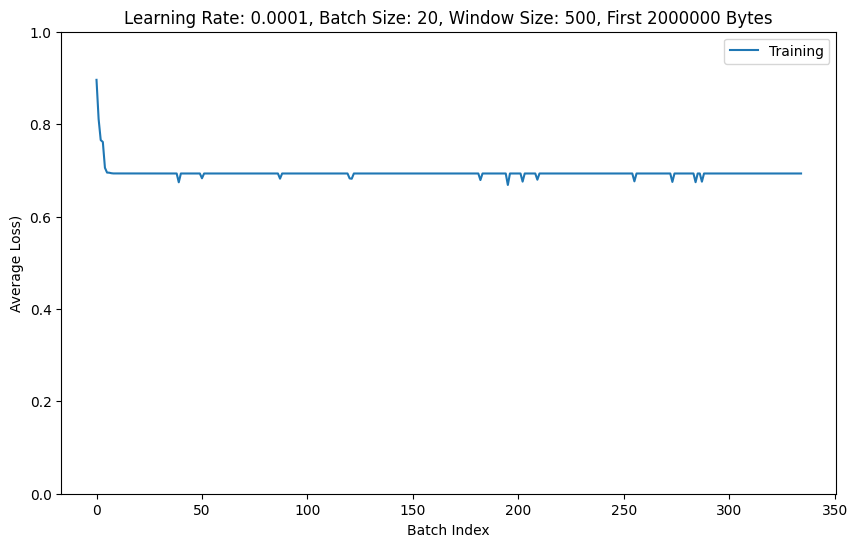

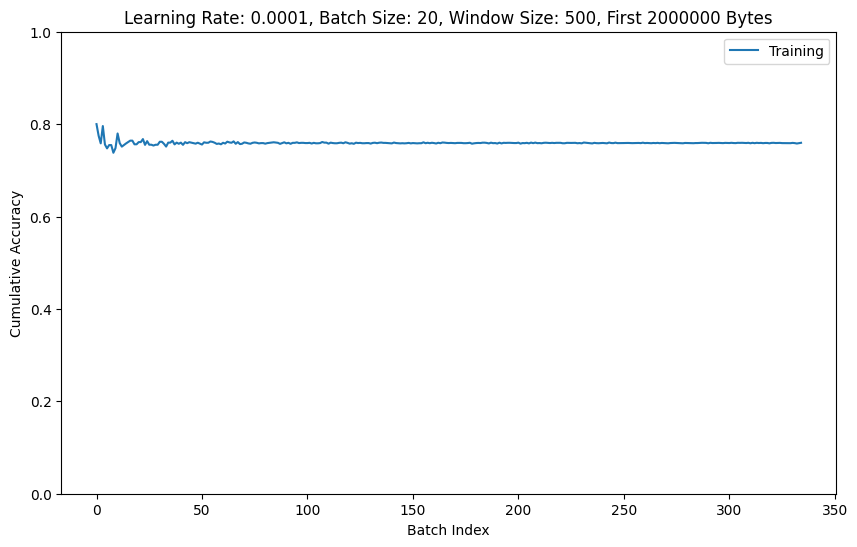

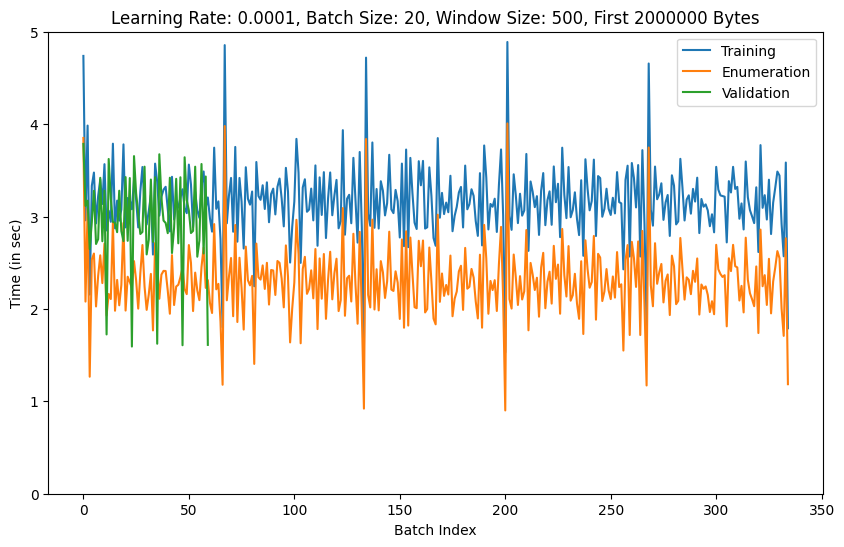

Training Dataloader Creation: 0.00021848199867235962
Validation Dataloader Creation: 0.00017458699949202128


In [113]:
x = range(len(epoch_stats['tr_loss']))

x2 = range(len(epoch_stats['val_loss']))
plt.figure(figsize=(10,6))
plt.plot(x,  epoch_stats['tr_loss'], label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Average Loss)")
plt.ylim([0, 1])
plt.legend()
plt.show()

cum_acc = []
for i in range(len(epoch_stats['tr_acc'])):
    cum_acc.append(np.mean(cum_acc + [epoch_stats['tr_acc'][i]]))
    
plt.figure(figsize=(10,6))
plt.plot(x,  cum_acc, label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Cumulative Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(x, epoch_stats['tr_time'], label = "Training")
plt.plot(x, epoch_stats['enum_time'], label = "Enumeration")
plt.plot(x2, epoch_stats['val_time'], label = "Validation")
plt.legend()
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Time (in sec)")
plt.ylim([0, 5])
plt.show()

print("Training Dataloader Creation: " + str(dataloader_create_train))
print("Validation Dataloader Creation: " + str(dataloader_create_test))

res_dict = {'cum_acc': cum_acc, 'val_time':epoch_stats['val_time'],'tr_time':epoch_stats['tr_time'], 'enum_time':epoch_stats['enum_time'], 'tr_loss':epoch_stats['tr_loss'], 'val_loss':epoch_stats['val_loss'],  'tr_acc':epoch_stats['tr_acc'],  'val_acc':epoch_stats['val_acc']}

with open('log/'+exp_name+'.pickle','wb') as handle:
	pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [114]:
config_path = "example.yaml" 
seed = 13
conf = yaml.safe_load(open(config_path,'r'))

exp_name = conf['exp_name']+'_sd_'+str(seed)
print('Experiment:')
print('\t',exp_name)

np.random.seed(seed)
torch.manual_seed(seed)

train_data_path = conf['train_data_path']
train_label_path = conf['train_label_path']

valid_data_path = conf['valid_data_path']
valid_label_path = conf['valid_label_path']

log_dir = conf['log_dir']
pred_dir = conf['pred_dir']
checkpoint_dir = conf['checkpoint_dir']


log_file_path = log_dir+exp_name+'.log'
chkpt_acc_path = checkpoint_dir+exp_name+'.model'
pred_path = pred_dir+exp_name+'.pred'

# Parameters
learning_rate = 0.00005
batch_size = 20
first_n_byte = 2000000
window_size = 500
use_gpu = conf['use_gpu']
use_cpu = conf['use_cpu']
max_step = conf['max_step']
test_step = conf['test_step']
display_step = conf['display_step']

sample_cnt = conf['sample_cnt']

# Load Ground Truth.
tr_label_table = pd.read_csv(train_label_path,header=None,index_col=0)
tr_label_table.index=tr_label_table.index.str.upper()
tr_label_table = tr_label_table.rename(columns={1:'ground_truth'})
val_label_table = pd.read_csv(valid_label_path,header=None,index_col=0)
val_label_table.index=val_label_table.index.str.upper()
val_label_table = val_label_table.rename(columns={1:'ground_truth'})

# Merge Tables and remove duplicate
tr_table = tr_label_table.groupby(level=0).last()
del tr_label_table
val_table = val_label_table.groupby(level=0).last()
del val_label_table
tr_table = tr_table.drop(val_table.index.join(tr_table.index, how='inner'))

print('Training Set:')
print('\tTotal',len(tr_table),'files')
print('\tMalware Count :',tr_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',tr_table['ground_truth'].value_counts()[0])


print('Validation Set:')
print('\tTotal',len(val_table),'files')
print('\tMalware Count :',val_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',val_table['ground_truth'].value_counts()[0])

if sample_cnt != 1:
    tr_table = tr_table.sample(n=sample_cnt,random_state=seed)

dataset_test = ExeDataset(list(tr_table.index), train_data_path, list(tr_table.ground_truth),first_n_byte)

start_train=time.perf_counter()
dataloader = DataLoader(dataset_test , batch_size=batch_size, shuffle=True, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_train = end_train-start_train
start_train=time.perf_counter()

validloader = DataLoader(ExeDataset(list(val_table.index), valid_data_path, list(val_table.ground_truth),first_n_byte),
                        batch_size=batch_size, shuffle=False, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_test = end_train-start_train

valid_idx = list(val_table.index)

malconv = MalConv(input_length=first_n_byte,window_size=window_size)
bce_loss = nn.BCEWithLogitsLoss()
adam_optim = optim.Adam([{'params':malconv.parameters()}],lr=learning_rate)
sigmoid = nn.Sigmoid()

if use_gpu:
    malconv = malconv.cuda()
    bce_loss = bce_loss.cuda()
    sigmoid = sigmoid.cuda()


step_msg = 'step-{}-loss-{:.6f}-acc-{:.4f}-time-{:.2f}'
valid_msg = 'step-{}-tr_loss-{:.6f}-tr_acc-{:.4f}-val_loss-{:.6f}-val_acc-{:.4f}'
log_msg = '{}, {:.6f}, {:.4f}, {:.6f}, {:.4f}, {:.2f}'
history = {}
history['val_loss'] = []
history['val_acc'] = []
history['val_pred'] = []
history['tr_loss'] = []
history['tr_acc'] = []
history['tr_time'] = []
history['val_time'] = []
history['enum_time'] = []

epoch_stats = {}
epoch_stats['val_loss'] = []
epoch_stats['val_acc'] = []
epoch_stats['val_pred'] = []
epoch_stats['tr_loss'] = []
epoch_stats['tr_acc'] = []
epoch_stats['tr_time'] = []
epoch_stats['val_time'] = []
epoch_stats['enum_time'] = []

log = open(log_file_path,'w')
log.write('step,tr_loss, tr_acc, val_loss, val_acc, time\n')

valid_best_acc = 0.0
total_step = 0
step_cost_time = 0

epoch = 0
max_epochs = 5
while epoch < max_epochs:
    print("EPOCH: "+ str(epoch))
    # Training 
    print("TRAINING:")
    start = time.perf_counter()
    for step,batch_data in enumerate(dataloader):
        end_enum = time.perf_counter()-start
        adam_optim.zero_grad()
        
        cur_batch_size = batch_data[0].size(0)

        exe_input = batch_data[0].cuda() if use_gpu else batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        
        label = batch_data[1].cuda() if use_gpu else batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        
        if (len(exe_input) <= 1):
          print(f"file too small: {len(exe_input)}")
          continue
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        loss.backward()
        history['tr_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['tr_acc'].append(batch_pred)
        step_cost_time = time.perf_counter()-start
        history['tr_time'].append(step_cost_time)
        history['enum_time'].append(end_enum)
        print("loss: " +str(np.mean(history['tr_loss'])) + " acc: " + str(np.mean(history['tr_acc'])) + " time: " + str(step_cost_time))
        adam_optim.step()
        start = time.perf_counter()
    
    print("VALIDATION:")
    start = time.perf_counter()
    for _,val_batch_data in enumerate(validloader):
        cur_batch_size = val_batch_data[0].size(0)
        exe_input = val_batch_data[0].cuda() if use_gpu else val_batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        label = val_batch_data[1].cuda() if use_gpu else val_batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        step_cost_time = time.perf_counter()-start
        history['val_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['val_acc'].append(batch_pred)
        history['val_pred'].append(list(pred.cpu().data.numpy()))
        history['val_time'].append(step_cost_time)
        print("loss: " +str(np.mean(history['val_loss'])) + " acc: " + str(np.mean(history['val_acc'])) + " time: " + str(step_cost_time))
        start = time.perf_counter()
    print(log_msg.format(total_step, np.mean(history['tr_loss']), np.mean(history['tr_acc']),
                    np.mean(history['val_loss']), np.mean(history['val_acc']),step_cost_time),
          file=log,flush=True)
    
    print(valid_msg.format(total_step,np.mean(history['tr_loss']),np.mean(history['tr_acc']),
                           np.mean(history['val_loss']),np.mean(history['val_acc'])))
    if valid_best_acc < np.mean(history['val_acc']):
        valid_best_acc = np.mean(history['val_acc'])
        torch.save(malconv,chkpt_acc_path)
        print('Checkpoint saved at',chkpt_acc_path)
        write_pred(history['val_pred'],valid_idx,pred_path)
        print('Prediction saved at', pred_path)
    epoch += 1
    epoch_stats['val_loss'].extend(history['val_loss'])
    epoch_stats['val_acc'].extend(history['val_acc'])
    epoch_stats['val_pred'].extend(history['val_pred'])
    epoch_stats['tr_loss'].extend(history['tr_loss'])
    epoch_stats['tr_acc'].extend(history['tr_acc'])
    epoch_stats['tr_time'].extend(history['tr_time'])
    epoch_stats['val_time'].extend(history['val_time'])
    epoch_stats['enum_time'].extend(history['enum_time'])
    history['val_loss'] = []
    history['val_acc'] = []
    history['val_pred'] = []
    history['tr_loss'] = []
    history['tr_acc'] = []
    history['tr_time'] = []
    history['val_time'] = []
    history['enum_time'] = []

Experiment:
	 example_sd_13
Training Set:
	Total 1335 files
	Malware Count : 387
	Goodware Count: 948
Validation Set:
	Total 236 files
	Malware Count : 64
	Goodware Count: 172
EPOCH: 0
TRAINING:
loss: 0.84670705 acc: 0.3 time: 4.741131277998647
loss: 0.76122206 acc: 0.44999999999999996 time: 3.2137179159999505
loss: 0.78948355 acc: 0.39999999999999997 time: 3.2955081069994776
loss: 0.81620574 acc: 0.35 time: 2.821059616999264
loss: 0.8210726 acc: 0.33999999999999997 time: 3.312920952999775
loss: 0.80939406 acc: 0.35833333333333334 time: 3.3313946469988878
loss: 0.8082579 acc: 0.37142857142857144 time: 3.1584707599995454
loss: 0.80694985 acc: 0.38749999999999996 time: 3.089718231000006
loss: 0.8031873 acc: 0.4111111111111111 time: 3.0738447820003785
loss: 0.8127049 acc: 0.425 time: 3.216811031999896
loss: 0.81782126 acc: 0.45454545454545453 time: 3.1461277669986885
loss: 0.82171637 acc: 0.47500000000000003 time: 2.550689556999714
loss: 0.8248429 acc: 0.49230769230769234 time: 3.66843401

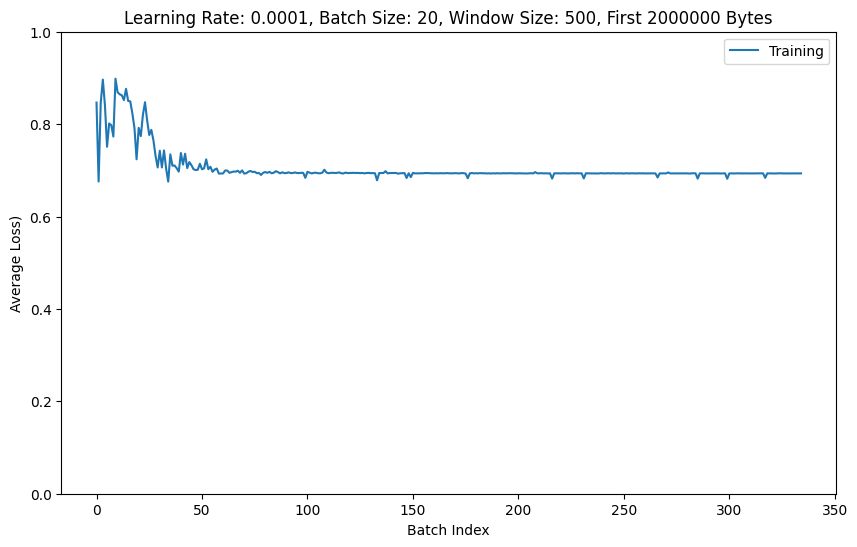

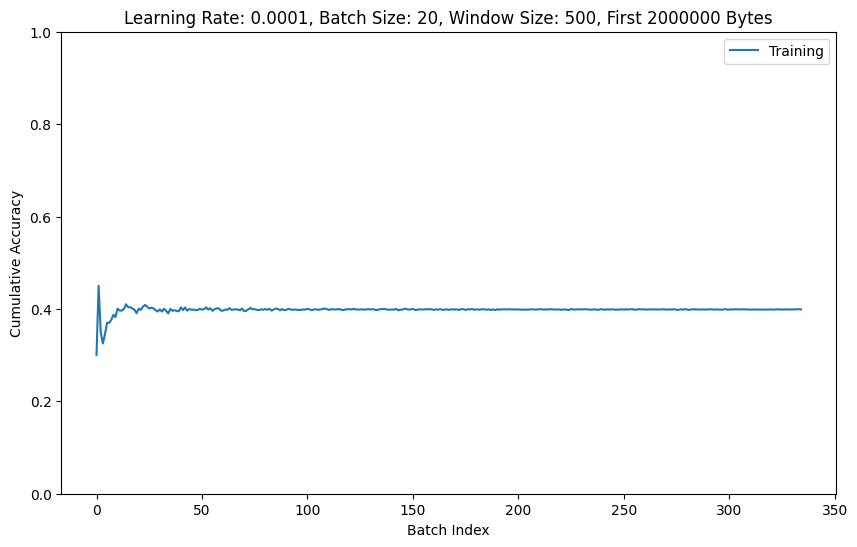

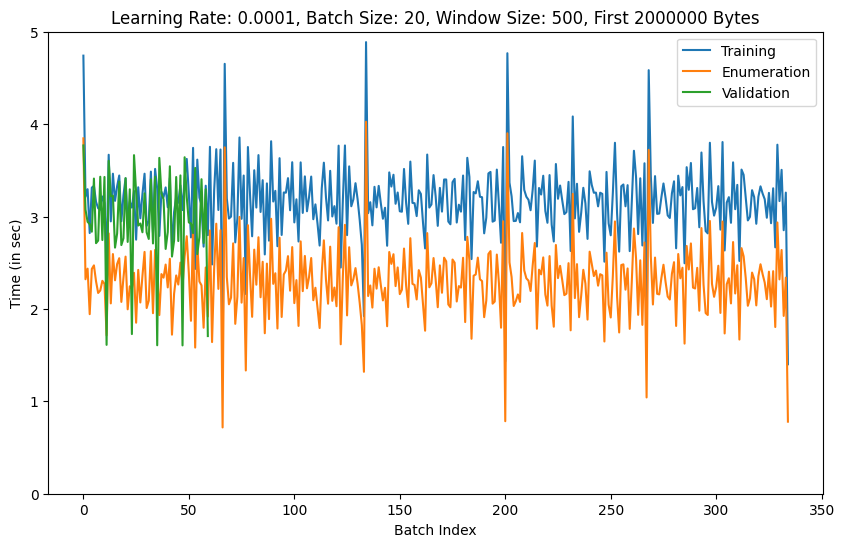

Training Dataloader Creation: 0.00021221099996182602
Validation Dataloader Creation: 0.00017171699983009603


In [115]:
x = range(len(epoch_stats['tr_loss']))

x2 = range(len(epoch_stats['val_loss']))
plt.figure(figsize=(10,6))
plt.plot(x,  epoch_stats['tr_loss'], label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Average Loss)")
plt.ylim([0, 1])
plt.legend()
plt.show()

cum_acc = []
for i in range(len(epoch_stats['tr_acc'])):
    cum_acc.append(np.mean(cum_acc + [epoch_stats['tr_acc'][i]]))
    
plt.figure(figsize=(10,6))
plt.plot(x,  cum_acc, label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Cumulative Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(x, epoch_stats['tr_time'], label = "Training")
plt.plot(x, epoch_stats['enum_time'], label = "Enumeration")
plt.plot(x2, epoch_stats['val_time'], label = "Validation")
plt.legend()
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Time (in sec)")
plt.ylim([0, 5])
plt.show()

print("Training Dataloader Creation: " + str(dataloader_create_train))
print("Validation Dataloader Creation: " + str(dataloader_create_test))

res_dict = {'cum_acc': cum_acc, 'val_time':epoch_stats['val_time'],'tr_time':epoch_stats['tr_time'], 'enum_time':epoch_stats['enum_time'], 'tr_loss':epoch_stats['tr_loss'], 'val_loss':epoch_stats['val_loss'],  'tr_acc':epoch_stats['tr_acc'],  'val_acc':epoch_stats['val_acc']}

with open('log/'+exp_name+'.pickle','wb') as handle:
	pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [116]:
config_path = "example.yaml" 
seed = 14
conf = yaml.safe_load(open(config_path,'r'))

exp_name = conf['exp_name']+'_sd_'+str(seed)
print('Experiment:')
print('\t',exp_name)

np.random.seed(seed)
torch.manual_seed(seed)

train_data_path = conf['train_data_path']
train_label_path = conf['train_label_path']

valid_data_path = conf['valid_data_path']
valid_label_path = conf['valid_label_path']

log_dir = conf['log_dir']
pred_dir = conf['pred_dir']
checkpoint_dir = conf['checkpoint_dir']


log_file_path = log_dir+exp_name+'.log'
chkpt_acc_path = checkpoint_dir+exp_name+'.model'
pred_path = pred_dir+exp_name+'.pred'

# Parameters
learning_rate = 0.0001
batch_size = 40
first_n_byte = 2000000
window_size = 500
use_gpu = conf['use_gpu']
use_cpu = conf['use_cpu']
max_step = conf['max_step']
test_step = conf['test_step']
display_step = conf['display_step']

sample_cnt = conf['sample_cnt']

# Load Ground Truth.
tr_label_table = pd.read_csv(train_label_path,header=None,index_col=0)
tr_label_table.index=tr_label_table.index.str.upper()
tr_label_table = tr_label_table.rename(columns={1:'ground_truth'})
val_label_table = pd.read_csv(valid_label_path,header=None,index_col=0)
val_label_table.index=val_label_table.index.str.upper()
val_label_table = val_label_table.rename(columns={1:'ground_truth'})

# Merge Tables and remove duplicate
tr_table = tr_label_table.groupby(level=0).last()
del tr_label_table
val_table = val_label_table.groupby(level=0).last()
del val_label_table
tr_table = tr_table.drop(val_table.index.join(tr_table.index, how='inner'))

print('Training Set:')
print('\tTotal',len(tr_table),'files')
print('\tMalware Count :',tr_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',tr_table['ground_truth'].value_counts()[0])


print('Validation Set:')
print('\tTotal',len(val_table),'files')
print('\tMalware Count :',val_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',val_table['ground_truth'].value_counts()[0])

if sample_cnt != 1:
    tr_table = tr_table.sample(n=sample_cnt,random_state=seed)

dataset_test = ExeDataset(list(tr_table.index), train_data_path, list(tr_table.ground_truth),first_n_byte)

start_train=time.perf_counter()
dataloader = DataLoader(dataset_test , batch_size=batch_size, shuffle=True, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_train = end_train-start_train
start_train=time.perf_counter()

validloader = DataLoader(ExeDataset(list(val_table.index), valid_data_path, list(val_table.ground_truth),first_n_byte),
                        batch_size=batch_size, shuffle=False, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_test = end_train-start_train

valid_idx = list(val_table.index)

malconv = MalConv(input_length=first_n_byte,window_size=window_size)
bce_loss = nn.BCEWithLogitsLoss()
adam_optim = optim.Adam([{'params':malconv.parameters()}],lr=learning_rate)
sigmoid = nn.Sigmoid()

if use_gpu:
    malconv = malconv.cuda()
    bce_loss = bce_loss.cuda()
    sigmoid = sigmoid.cuda()


step_msg = 'step-{}-loss-{:.6f}-acc-{:.4f}-time-{:.2f}'
valid_msg = 'step-{}-tr_loss-{:.6f}-tr_acc-{:.4f}-val_loss-{:.6f}-val_acc-{:.4f}'
log_msg = '{}, {:.6f}, {:.4f}, {:.6f}, {:.4f}, {:.2f}'
history = {}
history['val_loss'] = []
history['val_acc'] = []
history['val_pred'] = []
history['tr_loss'] = []
history['tr_acc'] = []
history['tr_time'] = []
history['val_time'] = []
history['enum_time'] = []

epoch_stats = {}
epoch_stats['val_loss'] = []
epoch_stats['val_acc'] = []
epoch_stats['val_pred'] = []
epoch_stats['tr_loss'] = []
epoch_stats['tr_acc'] = []
epoch_stats['tr_time'] = []
epoch_stats['val_time'] = []
epoch_stats['enum_time'] = []

log = open(log_file_path,'w')
log.write('step,tr_loss, tr_acc, val_loss, val_acc, time\n')

valid_best_acc = 0.0
total_step = 0
step_cost_time = 0

epoch = 0
max_epochs = 5
while epoch < max_epochs:
    print("EPOCH: "+ str(epoch))
    # Training 
    print("TRAINING:")
    start = time.perf_counter()
    for step,batch_data in enumerate(dataloader):
        end_enum = time.perf_counter()-start
        adam_optim.zero_grad()
        
        cur_batch_size = batch_data[0].size(0)

        exe_input = batch_data[0].cuda() if use_gpu else batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        
        label = batch_data[1].cuda() if use_gpu else batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        
        if (len(exe_input) <= 1):
          print(f"file too small: {len(exe_input)}")
          continue
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        loss.backward()
        history['tr_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['tr_acc'].append(batch_pred)
        step_cost_time = time.perf_counter()-start
        history['tr_time'].append(step_cost_time)
        history['enum_time'].append(end_enum)
        print("loss: " +str(np.mean(history['tr_loss'])) + " acc: " + str(np.mean(history['tr_acc'])) + " time: " + str(step_cost_time))
        adam_optim.step()
        start = time.perf_counter()
    
    print("VALIDATION:")
    start = time.perf_counter()
    for _,val_batch_data in enumerate(validloader):
        cur_batch_size = val_batch_data[0].size(0)
        exe_input = val_batch_data[0].cuda() if use_gpu else val_batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        label = val_batch_data[1].cuda() if use_gpu else val_batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        step_cost_time = time.perf_counter()-start
        history['val_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['val_acc'].append(batch_pred)
        history['val_pred'].append(list(pred.cpu().data.numpy()))
        history['val_time'].append(step_cost_time)
        print("loss: " +str(np.mean(history['val_loss'])) + " acc: " + str(np.mean(history['val_acc'])) + " time: " + str(step_cost_time))
        start = time.perf_counter()
    print(log_msg.format(total_step, np.mean(history['tr_loss']), np.mean(history['tr_acc']),
                    np.mean(history['val_loss']), np.mean(history['val_acc']),step_cost_time),
          file=log,flush=True)
    
    print(valid_msg.format(total_step,np.mean(history['tr_loss']),np.mean(history['tr_acc']),
                           np.mean(history['val_loss']),np.mean(history['val_acc'])))
    if valid_best_acc < np.mean(history['val_acc']):
        valid_best_acc = np.mean(history['val_acc'])
        torch.save(malconv,chkpt_acc_path)
        print('Checkpoint saved at',chkpt_acc_path)
        write_pred(history['val_pred'],valid_idx,pred_path)
        print('Prediction saved at', pred_path)
    epoch += 1
    epoch_stats['val_loss'].extend(history['val_loss'])
    epoch_stats['val_acc'].extend(history['val_acc'])
    epoch_stats['val_pred'].extend(history['val_pred'])
    epoch_stats['tr_loss'].extend(history['tr_loss'])
    epoch_stats['tr_acc'].extend(history['tr_acc'])
    epoch_stats['tr_time'].extend(history['tr_time'])
    epoch_stats['val_time'].extend(history['val_time'])
    epoch_stats['enum_time'].extend(history['enum_time'])
    history['val_loss'] = []
    history['val_acc'] = []
    history['val_pred'] = []
    history['tr_loss'] = []
    history['tr_acc'] = []
    history['tr_time'] = []
    history['val_time'] = []
    history['enum_time'] = []

Experiment:
	 example_sd_14
Training Set:
	Total 1335 files
	Malware Count : 387
	Goodware Count: 948
Validation Set:
	Total 236 files
	Malware Count : 64
	Goodware Count: 172
EPOCH: 0
TRAINING:
loss: 0.78287756 acc: 0.575 time: 8.832124734999525
loss: 0.78903395 acc: 0.625 time: 6.254225425000186
loss: 0.79898316 acc: 0.6666666666666666 time: 6.693748723999306
loss: 0.7878266 acc: 0.65625 time: 6.062761790999502
loss: 0.7903231 acc: 0.6849999999999999 time: 6.099253772001248
loss: 0.7813766 acc: 0.6749999999999999 time: 6.728935627001192
loss: 0.78097254 acc: 0.7 time: 6.410416612001427
loss: 0.77576256 acc: 0.70625 time: 6.326673259001836
loss: 0.77071494 acc: 0.7166666666666667 time: 5.961809307998919
loss: 0.76536924 acc: 0.7175 time: 6.196643208997557
loss: 0.7601457 acc: 0.7204545454545455 time: 6.5425115280013415
loss: 0.75518495 acc: 0.71875 time: 6.28886103199693
loss: 0.7507124 acc: 0.7153846153846154 time: 6.372710394000023
loss: 0.7471766 acc: 0.7142857142857143 time: 6.060

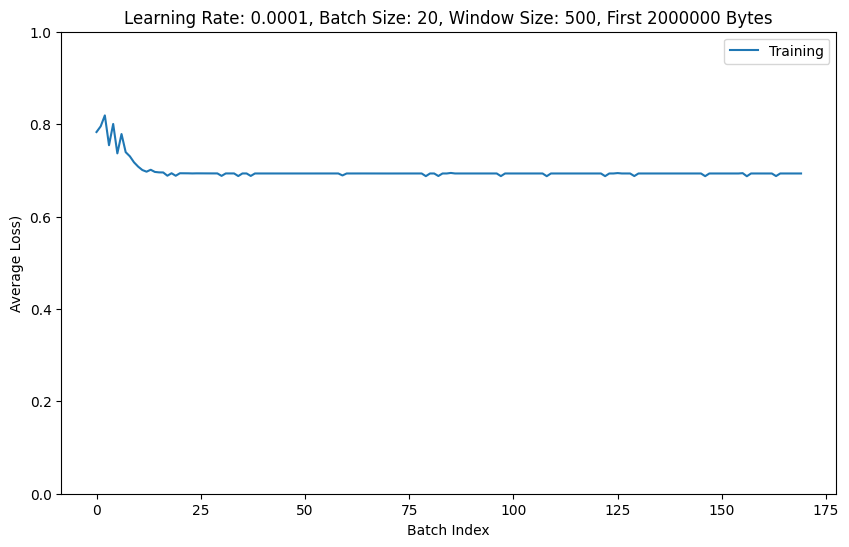

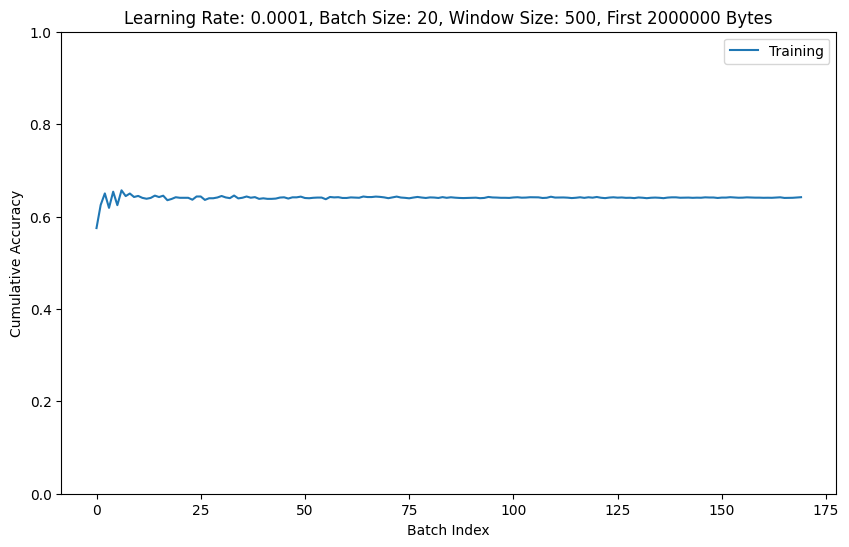

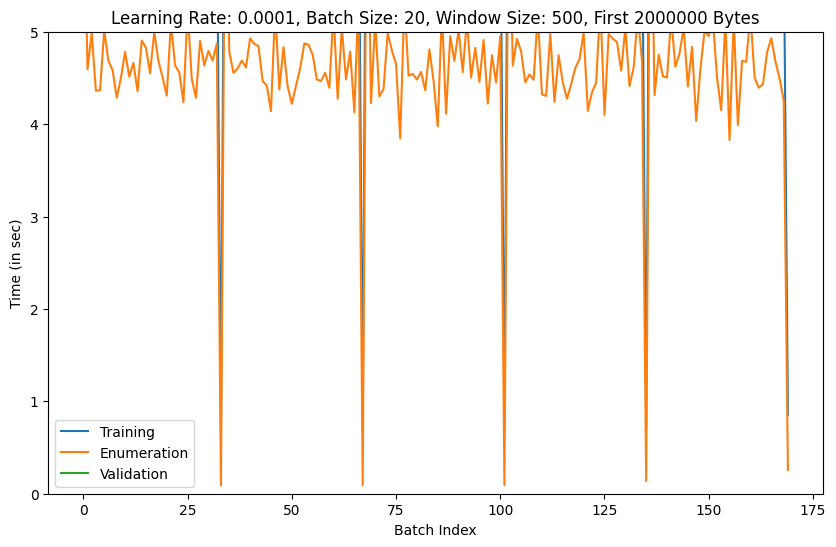

Training Dataloader Creation: 0.00022093000006861985
Validation Dataloader Creation: 0.00019009899915545247


In [117]:
x = range(len(epoch_stats['tr_loss']))

x2 = range(len(epoch_stats['val_loss']))
plt.figure(figsize=(10,6))
plt.plot(x,  epoch_stats['tr_loss'], label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Average Loss)")
plt.ylim([0, 1])
plt.legend()
plt.show()

cum_acc = []
for i in range(len(epoch_stats['tr_acc'])):
    cum_acc.append(np.mean(cum_acc + [epoch_stats['tr_acc'][i]]))
    
plt.figure(figsize=(10,6))
plt.plot(x,  cum_acc, label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Cumulative Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(x, epoch_stats['tr_time'], label = "Training")
plt.plot(x, epoch_stats['enum_time'], label = "Enumeration")
plt.plot(x2, epoch_stats['val_time'], label = "Validation")
plt.legend()
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Time (in sec)")
plt.ylim([0, 5])
plt.show()

print("Training Dataloader Creation: " + str(dataloader_create_train))
print("Validation Dataloader Creation: " + str(dataloader_create_test))

res_dict = {'cum_acc': cum_acc, 'val_time':epoch_stats['val_time'],'tr_time':epoch_stats['tr_time'], 'enum_time':epoch_stats['enum_time'], 'tr_loss':epoch_stats['tr_loss'], 'val_loss':epoch_stats['val_loss'],  'tr_acc':epoch_stats['tr_acc'],  'val_acc':epoch_stats['val_acc']}

with open('log/'+exp_name+'.pickle','wb') as handle:
	pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [118]:
config_path = "example.yaml" 
seed = 15
conf = yaml.safe_load(open(config_path,'r'))

exp_name = conf['exp_name']+'_sd_'+str(seed)
print('Experiment:')
print('\t',exp_name)

np.random.seed(seed)
torch.manual_seed(seed)

train_data_path = conf['train_data_path']
train_label_path = conf['train_label_path']

valid_data_path = conf['valid_data_path']
valid_label_path = conf['valid_label_path']

log_dir = conf['log_dir']
pred_dir = conf['pred_dir']
checkpoint_dir = conf['checkpoint_dir']


log_file_path = log_dir+exp_name+'.log'
chkpt_acc_path = checkpoint_dir+exp_name+'.model'
pred_path = pred_dir+exp_name+'.pred'

# Parameters
learning_rate = 0.0001
batch_size = 10
first_n_byte = 2000000
window_size = 500
use_gpu = conf['use_gpu']
use_cpu = conf['use_cpu']
max_step = conf['max_step']
test_step = conf['test_step']
display_step = conf['display_step']

sample_cnt = conf['sample_cnt']

# Load Ground Truth.
tr_label_table = pd.read_csv(train_label_path,header=None,index_col=0)
tr_label_table.index=tr_label_table.index.str.upper()
tr_label_table = tr_label_table.rename(columns={1:'ground_truth'})
val_label_table = pd.read_csv(valid_label_path,header=None,index_col=0)
val_label_table.index=val_label_table.index.str.upper()
val_label_table = val_label_table.rename(columns={1:'ground_truth'})

# Merge Tables and remove duplicate
tr_table = tr_label_table.groupby(level=0).last()
del tr_label_table
val_table = val_label_table.groupby(level=0).last()
del val_label_table
tr_table = tr_table.drop(val_table.index.join(tr_table.index, how='inner'))

print('Training Set:')
print('\tTotal',len(tr_table),'files')
print('\tMalware Count :',tr_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',tr_table['ground_truth'].value_counts()[0])


print('Validation Set:')
print('\tTotal',len(val_table),'files')
print('\tMalware Count :',val_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',val_table['ground_truth'].value_counts()[0])

if sample_cnt != 1:
    tr_table = tr_table.sample(n=sample_cnt,random_state=seed)

dataset_test = ExeDataset(list(tr_table.index), train_data_path, list(tr_table.ground_truth),first_n_byte)

start_train=time.perf_counter()
dataloader = DataLoader(dataset_test , batch_size=batch_size, shuffle=True, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_train = end_train-start_train
start_train=time.perf_counter()

validloader = DataLoader(ExeDataset(list(val_table.index), valid_data_path, list(val_table.ground_truth),first_n_byte),
                        batch_size=batch_size, shuffle=False, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_test = end_train-start_train

valid_idx = list(val_table.index)

malconv = MalConv(input_length=first_n_byte,window_size=window_size)
bce_loss = nn.BCEWithLogitsLoss()
adam_optim = optim.Adam([{'params':malconv.parameters()}],lr=learning_rate)
sigmoid = nn.Sigmoid()

if use_gpu:
    malconv = malconv.cuda()
    bce_loss = bce_loss.cuda()
    sigmoid = sigmoid.cuda()


step_msg = 'step-{}-loss-{:.6f}-acc-{:.4f}-time-{:.2f}'
valid_msg = 'step-{}-tr_loss-{:.6f}-tr_acc-{:.4f}-val_loss-{:.6f}-val_acc-{:.4f}'
log_msg = '{}, {:.6f}, {:.4f}, {:.6f}, {:.4f}, {:.2f}'
history = {}
history['val_loss'] = []
history['val_acc'] = []
history['val_pred'] = []
history['tr_loss'] = []
history['tr_acc'] = []
history['tr_time'] = []
history['val_time'] = []
history['enum_time'] = []

epoch_stats = {}
epoch_stats['val_loss'] = []
epoch_stats['val_acc'] = []
epoch_stats['val_pred'] = []
epoch_stats['tr_loss'] = []
epoch_stats['tr_acc'] = []
epoch_stats['tr_time'] = []
epoch_stats['val_time'] = []
epoch_stats['enum_time'] = []

log = open(log_file_path,'w')
log.write('step,tr_loss, tr_acc, val_loss, val_acc, time\n')

valid_best_acc = 0.0
total_step = 0
step_cost_time = 0

epoch = 0
max_epochs = 5
while epoch < max_epochs:
    print("EPOCH: "+ str(epoch))
    # Training 
    print("TRAINING:")
    start = time.perf_counter()
    for step,batch_data in enumerate(dataloader):
        end_enum = time.perf_counter()-start
        adam_optim.zero_grad()
        
        cur_batch_size = batch_data[0].size(0)

        exe_input = batch_data[0].cuda() if use_gpu else batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        
        label = batch_data[1].cuda() if use_gpu else batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        
        if (len(exe_input) <= 1):
          print(f"file too small: {len(exe_input)}")
          continue
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        loss.backward()
        history['tr_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['tr_acc'].append(batch_pred)
        step_cost_time = time.perf_counter()-start
        history['tr_time'].append(step_cost_time)
        history['enum_time'].append(end_enum)
        print("loss: " +str(np.mean(history['tr_loss'])) + " acc: " + str(np.mean(history['tr_acc'])) + " time: " + str(step_cost_time))
        adam_optim.step()
        start = time.perf_counter()
    
    print("VALIDATION:")
    start = time.perf_counter()
    for _,val_batch_data in enumerate(validloader):
        cur_batch_size = val_batch_data[0].size(0)
        exe_input = val_batch_data[0].cuda() if use_gpu else val_batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        label = val_batch_data[1].cuda() if use_gpu else val_batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        step_cost_time = time.perf_counter()-start
        history['val_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['val_acc'].append(batch_pred)
        history['val_pred'].append(list(pred.cpu().data.numpy()))
        history['val_time'].append(step_cost_time)
        print("loss: " +str(np.mean(history['val_loss'])) + " acc: " + str(np.mean(history['val_acc'])) + " time: " + str(step_cost_time))
        start = time.perf_counter()
    print(log_msg.format(total_step, np.mean(history['tr_loss']), np.mean(history['tr_acc']),
                    np.mean(history['val_loss']), np.mean(history['val_acc']),step_cost_time),
          file=log,flush=True)
    
    print(valid_msg.format(total_step,np.mean(history['tr_loss']),np.mean(history['tr_acc']),
                           np.mean(history['val_loss']),np.mean(history['val_acc'])))
    if valid_best_acc < np.mean(history['val_acc']):
        valid_best_acc = np.mean(history['val_acc'])
        torch.save(malconv,chkpt_acc_path)
        print('Checkpoint saved at',chkpt_acc_path)
        write_pred(history['val_pred'],valid_idx,pred_path)
        print('Prediction saved at', pred_path)
    epoch += 1
    epoch_stats['val_loss'].extend(history['val_loss'])
    epoch_stats['val_acc'].extend(history['val_acc'])
    epoch_stats['val_pred'].extend(history['val_pred'])
    epoch_stats['tr_loss'].extend(history['tr_loss'])
    epoch_stats['tr_acc'].extend(history['tr_acc'])
    epoch_stats['tr_time'].extend(history['tr_time'])
    epoch_stats['val_time'].extend(history['val_time'])
    epoch_stats['enum_time'].extend(history['enum_time'])
    history['val_loss'] = []
    history['val_acc'] = []
    history['val_pred'] = []
    history['tr_loss'] = []
    history['tr_acc'] = []
    history['tr_time'] = []
    history['val_time'] = []
    history['enum_time'] = []

Experiment:
	 example_sd_15
Training Set:
	Total 1335 files
	Malware Count : 387
	Goodware Count: 948
Validation Set:
	Total 236 files
	Malware Count : 64
	Goodware Count: 172
EPOCH: 0
TRAINING:
loss: 1.0671966 acc: 0.0 time: 2.3855013930005953
loss: 0.9656689 acc: 0.15 time: 1.9398086729997885
loss: 0.92666197 acc: 0.19999999999999998 time: 1.2996094190020813
loss: 0.8775501 acc: 0.275 time: 1.5436382230000163
loss: 0.88213855 acc: 0.26 time: 1.920969074999448
loss: 0.8919913 acc: 0.25 time: 1.3005026040009398
loss: 0.8603919 acc: 0.32857142857142857 time: 1.5607612400017388
loss: 0.8546463 acc: 0.3875 time: 1.5930828650016338
loss: 0.8337997 acc: 0.4222222222222222 time: 1.7002519889974792
loss: 0.84043723 acc: 0.47000000000000003 time: 1.8497881980001694
loss: 0.84085363 acc: 0.5 time: 1.6272660229988105
loss: 0.839788 acc: 0.525 time: 1.3455878039967502
loss: 0.838034 acc: 0.5461538461538461 time: 1.679164437999134
loss: 0.8337976 acc: 0.5571428571428572 time: 1.6205813710002985
lo

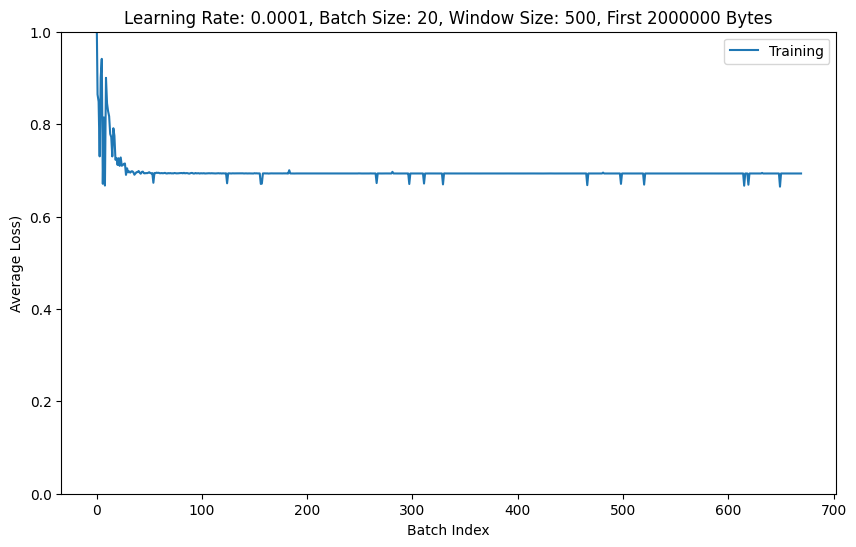

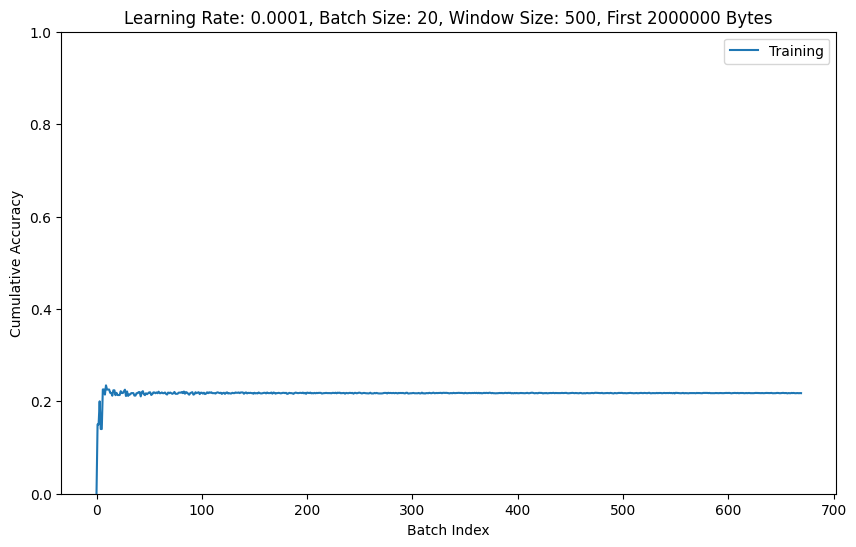

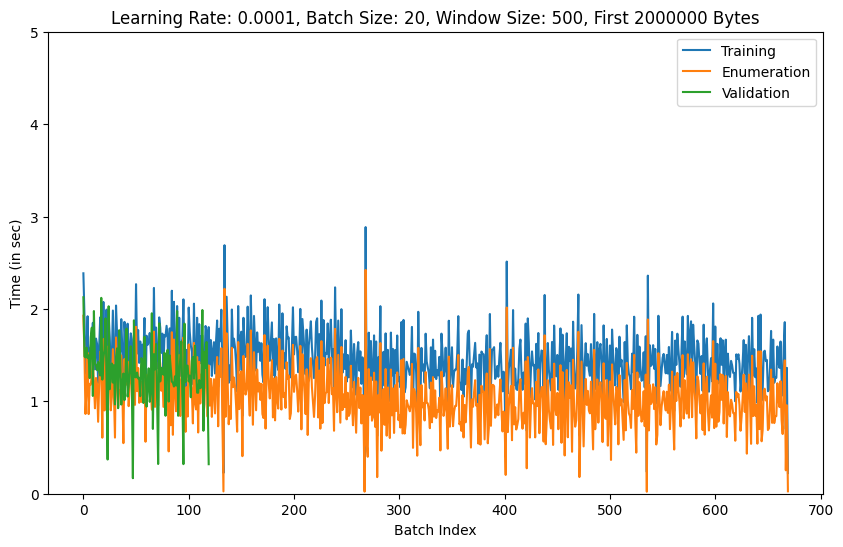

Training Dataloader Creation: 0.00022336799884214997
Validation Dataloader Creation: 0.00018716200065682642


In [119]:
x = range(len(epoch_stats['tr_loss']))

x2 = range(len(epoch_stats['val_loss']))
plt.figure(figsize=(10,6))
plt.plot(x,  epoch_stats['tr_loss'], label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Average Loss)")
plt.ylim([0, 1])
plt.legend()
plt.show()

cum_acc = []
for i in range(len(epoch_stats['tr_acc'])):
    cum_acc.append(np.mean(cum_acc + [epoch_stats['tr_acc'][i]]))
    
plt.figure(figsize=(10,6))
plt.plot(x,  cum_acc, label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Cumulative Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(x, epoch_stats['tr_time'], label = "Training")
plt.plot(x, epoch_stats['enum_time'], label = "Enumeration")
plt.plot(x2, epoch_stats['val_time'], label = "Validation")
plt.legend()
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Time (in sec)")
plt.ylim([0, 5])
plt.show()

print("Training Dataloader Creation: " + str(dataloader_create_train))
print("Validation Dataloader Creation: " + str(dataloader_create_test))

res_dict = {'cum_acc': cum_acc, 'val_time':epoch_stats['val_time'],'tr_time':epoch_stats['tr_time'], 'enum_time':epoch_stats['enum_time'], 'tr_loss':epoch_stats['tr_loss'], 'val_loss':epoch_stats['val_loss'],  'tr_acc':epoch_stats['tr_acc'],  'val_acc':epoch_stats['val_acc']}

with open('log/'+exp_name+'.pickle','wb') as handle:
	pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [120]:
config_path = "example.yaml" 
seed = 16
conf = yaml.safe_load(open(config_path,'r'))

exp_name = conf['exp_name']+'_sd_'+str(seed)
print('Experiment:')
print('\t',exp_name)

np.random.seed(seed)
torch.manual_seed(seed)

train_data_path = conf['train_data_path']
train_label_path = conf['train_label_path']

valid_data_path = conf['valid_data_path']
valid_label_path = conf['valid_label_path']

log_dir = conf['log_dir']
pred_dir = conf['pred_dir']
checkpoint_dir = conf['checkpoint_dir']


log_file_path = log_dir+exp_name+'.log'
chkpt_acc_path = checkpoint_dir+exp_name+'.model'
pred_path = pred_dir+exp_name+'.pred'

# Parameters
learning_rate = 0.0001
batch_size = 20
first_n_byte = 2000000
window_size = 250
use_gpu = conf['use_gpu']
use_cpu = conf['use_cpu']
max_step = conf['max_step']
test_step = conf['test_step']
display_step = conf['display_step']

sample_cnt = conf['sample_cnt']

# Load Ground Truth.
tr_label_table = pd.read_csv(train_label_path,header=None,index_col=0)
tr_label_table.index=tr_label_table.index.str.upper()
tr_label_table = tr_label_table.rename(columns={1:'ground_truth'})
val_label_table = pd.read_csv(valid_label_path,header=None,index_col=0)
val_label_table.index=val_label_table.index.str.upper()
val_label_table = val_label_table.rename(columns={1:'ground_truth'})

# Merge Tables and remove duplicate
tr_table = tr_label_table.groupby(level=0).last()
del tr_label_table
val_table = val_label_table.groupby(level=0).last()
del val_label_table
tr_table = tr_table.drop(val_table.index.join(tr_table.index, how='inner'))

print('Training Set:')
print('\tTotal',len(tr_table),'files')
print('\tMalware Count :',tr_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',tr_table['ground_truth'].value_counts()[0])


print('Validation Set:')
print('\tTotal',len(val_table),'files')
print('\tMalware Count :',val_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',val_table['ground_truth'].value_counts()[0])

if sample_cnt != 1:
    tr_table = tr_table.sample(n=sample_cnt,random_state=seed)

dataset_test = ExeDataset(list(tr_table.index), train_data_path, list(tr_table.ground_truth),first_n_byte)

start_train=time.perf_counter()
dataloader = DataLoader(dataset_test , batch_size=batch_size, shuffle=True, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_train = end_train-start_train
start_train=time.perf_counter()

validloader = DataLoader(ExeDataset(list(val_table.index), valid_data_path, list(val_table.ground_truth),first_n_byte),
                        batch_size=batch_size, shuffle=False, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_test = end_train-start_train

valid_idx = list(val_table.index)

malconv = MalConv(input_length=first_n_byte,window_size=window_size)
bce_loss = nn.BCEWithLogitsLoss()
adam_optim = optim.Adam([{'params':malconv.parameters()}],lr=learning_rate)
sigmoid = nn.Sigmoid()

if use_gpu:
    malconv = malconv.cuda()
    bce_loss = bce_loss.cuda()
    sigmoid = sigmoid.cuda()


step_msg = 'step-{}-loss-{:.6f}-acc-{:.4f}-time-{:.2f}'
valid_msg = 'step-{}-tr_loss-{:.6f}-tr_acc-{:.4f}-val_loss-{:.6f}-val_acc-{:.4f}'
log_msg = '{}, {:.6f}, {:.4f}, {:.6f}, {:.4f}, {:.2f}'
history = {}
history['val_loss'] = []
history['val_acc'] = []
history['val_pred'] = []
history['tr_loss'] = []
history['tr_acc'] = []
history['tr_time'] = []
history['val_time'] = []
history['enum_time'] = []

epoch_stats = {}
epoch_stats['val_loss'] = []
epoch_stats['val_acc'] = []
epoch_stats['val_pred'] = []
epoch_stats['tr_loss'] = []
epoch_stats['tr_acc'] = []
epoch_stats['tr_time'] = []
epoch_stats['val_time'] = []
epoch_stats['enum_time'] = []

log = open(log_file_path,'w')
log.write('step,tr_loss, tr_acc, val_loss, val_acc, time\n')

valid_best_acc = 0.0
total_step = 0
step_cost_time = 0

epoch = 0
max_epochs = 5
while epoch < max_epochs:
    print("EPOCH: "+ str(epoch))
    # Training 
    print("TRAINING:")
    start = time.perf_counter()
    for step,batch_data in enumerate(dataloader):
        end_enum = time.perf_counter()-start
        adam_optim.zero_grad()
        
        cur_batch_size = batch_data[0].size(0)

        exe_input = batch_data[0].cuda() if use_gpu else batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        
        label = batch_data[1].cuda() if use_gpu else batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        
        if (len(exe_input) <= 1):
          print(f"file too small: {len(exe_input)}")
          continue
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        loss.backward()
        history['tr_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['tr_acc'].append(batch_pred)
        step_cost_time = time.perf_counter()-start
        history['tr_time'].append(step_cost_time)
        history['enum_time'].append(end_enum)
        print("loss: " +str(np.mean(history['tr_loss'])) + " acc: " + str(np.mean(history['tr_acc'])) + " time: " + str(step_cost_time))
        adam_optim.step()
        start = time.perf_counter()
    
    print("VALIDATION:")
    start = time.perf_counter()
    for _,val_batch_data in enumerate(validloader):
        cur_batch_size = val_batch_data[0].size(0)
        exe_input = val_batch_data[0].cuda() if use_gpu else val_batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        label = val_batch_data[1].cuda() if use_gpu else val_batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        step_cost_time = time.perf_counter()-start
        history['val_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['val_acc'].append(batch_pred)
        history['val_pred'].append(list(pred.cpu().data.numpy()))
        history['val_time'].append(step_cost_time)
        print("loss: " +str(np.mean(history['val_loss'])) + " acc: " + str(np.mean(history['val_acc'])) + " time: " + str(step_cost_time))
        start = time.perf_counter()
    print(log_msg.format(total_step, np.mean(history['tr_loss']), np.mean(history['tr_acc']),
                    np.mean(history['val_loss']), np.mean(history['val_acc']),step_cost_time),
          file=log,flush=True)
    
    print(valid_msg.format(total_step,np.mean(history['tr_loss']),np.mean(history['tr_acc']),
                           np.mean(history['val_loss']),np.mean(history['val_acc'])))
    if valid_best_acc < np.mean(history['val_acc']):
        valid_best_acc = np.mean(history['val_acc'])
        torch.save(malconv,chkpt_acc_path)
        print('Checkpoint saved at',chkpt_acc_path)
        write_pred(history['val_pred'],valid_idx,pred_path)
        print('Prediction saved at', pred_path)
    epoch += 1
    epoch_stats['val_loss'].extend(history['val_loss'])
    epoch_stats['val_acc'].extend(history['val_acc'])
    epoch_stats['val_pred'].extend(history['val_pred'])
    epoch_stats['tr_loss'].extend(history['tr_loss'])
    epoch_stats['tr_acc'].extend(history['tr_acc'])
    epoch_stats['tr_time'].extend(history['tr_time'])
    epoch_stats['val_time'].extend(history['val_time'])
    epoch_stats['enum_time'].extend(history['enum_time'])
    history['val_loss'] = []
    history['val_acc'] = []
    history['val_pred'] = []
    history['tr_loss'] = []
    history['tr_acc'] = []
    history['tr_time'] = []
    history['val_time'] = []
    history['enum_time'] = []

Experiment:
	 example_sd_16
Training Set:
	Total 1335 files
	Malware Count : 387
	Goodware Count: 948
Validation Set:
	Total 236 files
	Malware Count : 64
	Goodware Count: 172
EPOCH: 0
TRAINING:
loss: 0.83700484 acc: 0.3 time: 4.290063434000331
loss: 0.88405913 acc: 0.22499999999999998 time: 2.637719759997708
loss: 0.8716863 acc: 0.3333333333333333 time: 2.8670021210018604
loss: 0.8569673 acc: 0.45 time: 2.599596685002325
loss: 0.84687454 acc: 0.5 time: 2.9598438069988333
loss: 0.84527725 acc: 0.5499999999999999 time: 2.444120791002206
loss: 0.8382353 acc: 0.5714285714285714 time: 2.9669445199979236
loss: 0.8291336 acc: 0.58125 time: 2.8662272690016835
loss: 0.82576823 acc: 0.6000000000000001 time: 2.0432150429987814
loss: 0.81825304 acc: 0.6050000000000001 time: 3.3382302460013307
loss: 0.8177462 acc: 0.6272727272727273 time: 2.8104255519974686
loss: 0.8064537 acc: 0.6125 time: 2.6224747150008625
loss: 0.8049315 acc: 0.6307692307692309 time: 2.759144660001766
loss: 0.79915655 acc: 0.6

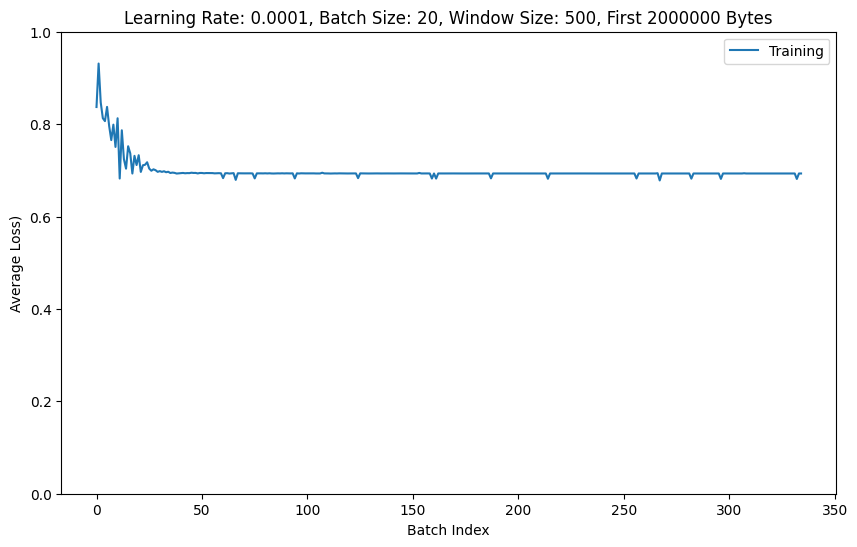

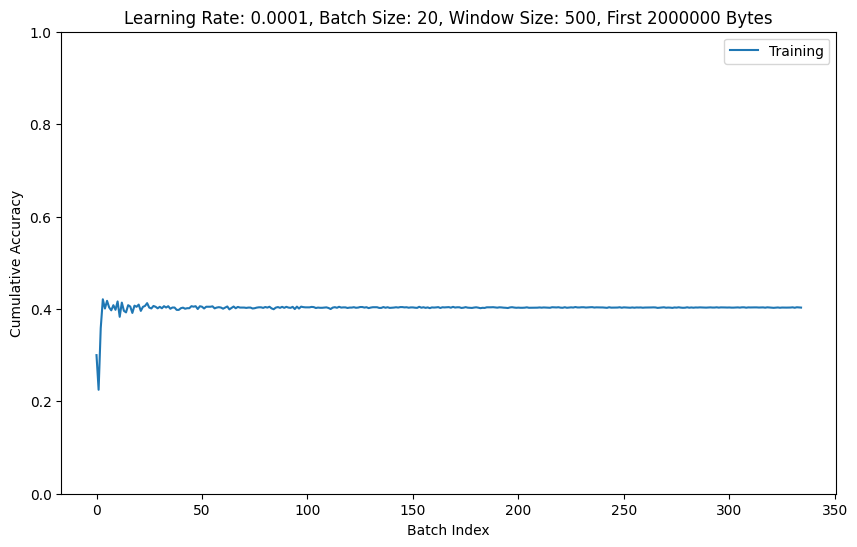

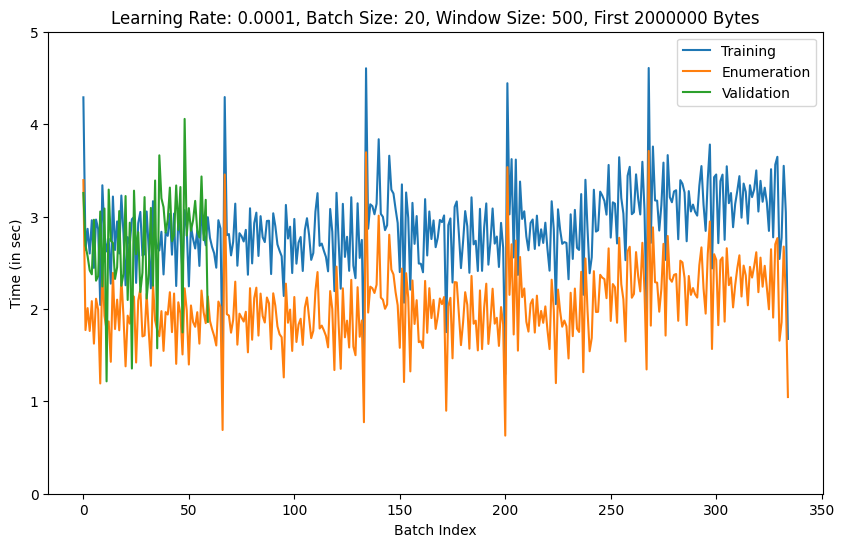

Training Dataloader Creation: 0.00016282500291708857
Validation Dataloader Creation: 0.00014006699711899273


In [121]:
x = range(len(epoch_stats['tr_loss']))

x2 = range(len(epoch_stats['val_loss']))
plt.figure(figsize=(10,6))
plt.plot(x,  epoch_stats['tr_loss'], label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Average Loss)")
plt.ylim([0, 1])
plt.legend()
plt.show()

cum_acc = []
for i in range(len(epoch_stats['tr_acc'])):
    cum_acc.append(np.mean(cum_acc + [epoch_stats['tr_acc'][i]]))
    
plt.figure(figsize=(10,6))
plt.plot(x,  cum_acc, label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Cumulative Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(x, epoch_stats['tr_time'], label = "Training")
plt.plot(x, epoch_stats['enum_time'], label = "Enumeration")
plt.plot(x2, epoch_stats['val_time'], label = "Validation")
plt.legend()
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Time (in sec)")
plt.ylim([0, 5])
plt.show()

print("Training Dataloader Creation: " + str(dataloader_create_train))
print("Validation Dataloader Creation: " + str(dataloader_create_test))

res_dict = {'cum_acc': cum_acc, 'val_time':epoch_stats['val_time'],'tr_time':epoch_stats['tr_time'], 'enum_time':epoch_stats['enum_time'], 'tr_loss':epoch_stats['tr_loss'], 'val_loss':epoch_stats['val_loss'],  'tr_acc':epoch_stats['tr_acc'],  'val_acc':epoch_stats['val_acc']}

with open('log/'+exp_name+'.pickle','wb') as handle:
	pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [122]:
config_path = "example.yaml" 
seed = 17
conf = yaml.safe_load(open(config_path,'r'))

exp_name = conf['exp_name']+'_sd_'+str(seed)
print('Experiment:')
print('\t',exp_name)

np.random.seed(seed)
torch.manual_seed(seed)

train_data_path = conf['train_data_path']
train_label_path = conf['train_label_path']

valid_data_path = conf['valid_data_path']
valid_label_path = conf['valid_label_path']

log_dir = conf['log_dir']
pred_dir = conf['pred_dir']
checkpoint_dir = conf['checkpoint_dir']


log_file_path = log_dir+exp_name+'.log'
chkpt_acc_path = checkpoint_dir+exp_name+'.model'
pred_path = pred_dir+exp_name+'.pred'

# Parameters
learning_rate = 0.0001
batch_size = 20
first_n_byte = 2000000
window_size = 750
use_gpu = conf['use_gpu']
use_cpu = conf['use_cpu']
max_step = conf['max_step']
test_step = conf['test_step']
display_step = conf['display_step']

sample_cnt = conf['sample_cnt']

# Load Ground Truth.
tr_label_table = pd.read_csv(train_label_path,header=None,index_col=0)
tr_label_table.index=tr_label_table.index.str.upper()
tr_label_table = tr_label_table.rename(columns={1:'ground_truth'})
val_label_table = pd.read_csv(valid_label_path,header=None,index_col=0)
val_label_table.index=val_label_table.index.str.upper()
val_label_table = val_label_table.rename(columns={1:'ground_truth'})

# Merge Tables and remove duplicate
tr_table = tr_label_table.groupby(level=0).last()
del tr_label_table
val_table = val_label_table.groupby(level=0).last()
del val_label_table
tr_table = tr_table.drop(val_table.index.join(tr_table.index, how='inner'))

print('Training Set:')
print('\tTotal',len(tr_table),'files')
print('\tMalware Count :',tr_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',tr_table['ground_truth'].value_counts()[0])


print('Validation Set:')
print('\tTotal',len(val_table),'files')
print('\tMalware Count :',val_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',val_table['ground_truth'].value_counts()[0])

if sample_cnt != 1:
    tr_table = tr_table.sample(n=sample_cnt,random_state=seed)

dataset_test = ExeDataset(list(tr_table.index), train_data_path, list(tr_table.ground_truth),first_n_byte)

start_train=time.perf_counter()
dataloader = DataLoader(dataset_test , batch_size=batch_size, shuffle=True, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_train = end_train-start_train
start_train=time.perf_counter()

validloader = DataLoader(ExeDataset(list(val_table.index), valid_data_path, list(val_table.ground_truth),first_n_byte),
                        batch_size=batch_size, shuffle=False, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_test = end_train-start_train

valid_idx = list(val_table.index)

malconv = MalConv(input_length=first_n_byte,window_size=window_size)
bce_loss = nn.BCEWithLogitsLoss()
adam_optim = optim.Adam([{'params':malconv.parameters()}],lr=learning_rate)
sigmoid = nn.Sigmoid()

if use_gpu:
    malconv = malconv.cuda()
    bce_loss = bce_loss.cuda()
    sigmoid = sigmoid.cuda()


step_msg = 'step-{}-loss-{:.6f}-acc-{:.4f}-time-{:.2f}'
valid_msg = 'step-{}-tr_loss-{:.6f}-tr_acc-{:.4f}-val_loss-{:.6f}-val_acc-{:.4f}'
log_msg = '{}, {:.6f}, {:.4f}, {:.6f}, {:.4f}, {:.2f}'
history = {}
history['val_loss'] = []
history['val_acc'] = []
history['val_pred'] = []
history['tr_loss'] = []
history['tr_acc'] = []
history['tr_time'] = []
history['val_time'] = []
history['enum_time'] = []

epoch_stats = {}
epoch_stats['val_loss'] = []
epoch_stats['val_acc'] = []
epoch_stats['val_pred'] = []
epoch_stats['tr_loss'] = []
epoch_stats['tr_acc'] = []
epoch_stats['tr_time'] = []
epoch_stats['val_time'] = []
epoch_stats['enum_time'] = []

log = open(log_file_path,'w')
log.write('step,tr_loss, tr_acc, val_loss, val_acc, time\n')

valid_best_acc = 0.0
total_step = 0
step_cost_time = 0

epoch = 0
max_epochs = 5
while epoch < max_epochs:
    print("EPOCH: "+ str(epoch))
    # Training 
    print("TRAINING:")
    start = time.perf_counter()
    for step,batch_data in enumerate(dataloader):
        end_enum = time.perf_counter()-start
        adam_optim.zero_grad()
        
        cur_batch_size = batch_data[0].size(0)

        exe_input = batch_data[0].cuda() if use_gpu else batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        
        label = batch_data[1].cuda() if use_gpu else batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        
        if (len(exe_input) <= 1):
          print(f"file too small: {len(exe_input)}")
          continue
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        loss.backward()
        history['tr_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['tr_acc'].append(batch_pred)
        step_cost_time = time.perf_counter()-start
        history['tr_time'].append(step_cost_time)
        history['enum_time'].append(end_enum)
        print("loss: " +str(np.mean(history['tr_loss'])) + " acc: " + str(np.mean(history['tr_acc'])) + " time: " + str(step_cost_time))
        adam_optim.step()
        start = time.perf_counter()
    
    print("VALIDATION:")
    start = time.perf_counter()
    for _,val_batch_data in enumerate(validloader):
        cur_batch_size = val_batch_data[0].size(0)
        exe_input = val_batch_data[0].cuda() if use_gpu else val_batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        label = val_batch_data[1].cuda() if use_gpu else val_batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        step_cost_time = time.perf_counter()-start
        history['val_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['val_acc'].append(batch_pred)
        history['val_pred'].append(list(pred.cpu().data.numpy()))
        history['val_time'].append(step_cost_time)
        print("loss: " +str(np.mean(history['val_loss'])) + " acc: " + str(np.mean(history['val_acc'])) + " time: " + str(step_cost_time))
        start = time.perf_counter()
    print(log_msg.format(total_step, np.mean(history['tr_loss']), np.mean(history['tr_acc']),
                    np.mean(history['val_loss']), np.mean(history['val_acc']),step_cost_time),
          file=log,flush=True)
    
    print(valid_msg.format(total_step,np.mean(history['tr_loss']),np.mean(history['tr_acc']),
                           np.mean(history['val_loss']),np.mean(history['val_acc'])))
    if valid_best_acc < np.mean(history['val_acc']):
        valid_best_acc = np.mean(history['val_acc'])
        torch.save(malconv,chkpt_acc_path)
        print('Checkpoint saved at',chkpt_acc_path)
        write_pred(history['val_pred'],valid_idx,pred_path)
        print('Prediction saved at', pred_path)
    epoch += 1
    epoch_stats['val_loss'].extend(history['val_loss'])
    epoch_stats['val_acc'].extend(history['val_acc'])
    epoch_stats['val_pred'].extend(history['val_pred'])
    epoch_stats['tr_loss'].extend(history['tr_loss'])
    epoch_stats['tr_acc'].extend(history['tr_acc'])
    epoch_stats['tr_time'].extend(history['tr_time'])
    epoch_stats['val_time'].extend(history['val_time'])
    epoch_stats['enum_time'].extend(history['enum_time'])
    history['val_loss'] = []
    history['val_acc'] = []
    history['val_pred'] = []
    history['tr_loss'] = []
    history['tr_acc'] = []
    history['tr_time'] = []
    history['val_time'] = []
    history['enum_time'] = []

Experiment:
	 example_sd_17
Training Set:
	Total 1335 files
	Malware Count : 387
	Goodware Count: 948
Validation Set:
	Total 236 files
	Malware Count : 64
	Goodware Count: 172
EPOCH: 0
TRAINING:
loss: 0.818182 acc: 0.75 time: 4.594168195999373
loss: 0.7972704 acc: 0.7 time: 3.3598373429995263
loss: 0.7961147 acc: 0.6999999999999998 time: 3.298146672997973
loss: 0.79834247 acc: 0.7124999999999999 time: 3.110805218002497
loss: 0.7881564 acc: 0.69 time: 3.144575802001782
loss: 0.7861883 acc: 0.6916666666666665 time: 3.280126730001939
loss: 0.78437984 acc: 0.6928571428571428 time: 3.1609918600006495
loss: 0.78342414 acc: 0.6937499999999999 time: 3.2411310889983724
loss: 0.77994484 acc: 0.6888888888888888 time: 3.1196717439997883
loss: 0.7784468 acc: 0.69 time: 3.010768364998512
loss: 0.780855 acc: 0.7045454545454545 time: 3.1699399829994945
loss: 0.7806718 acc: 0.7124999999999999 time: 2.8461446829969645
loss: 0.77664876 acc: 0.7076923076923076 time: 3.977367373998277
loss: 0.77368444 acc:

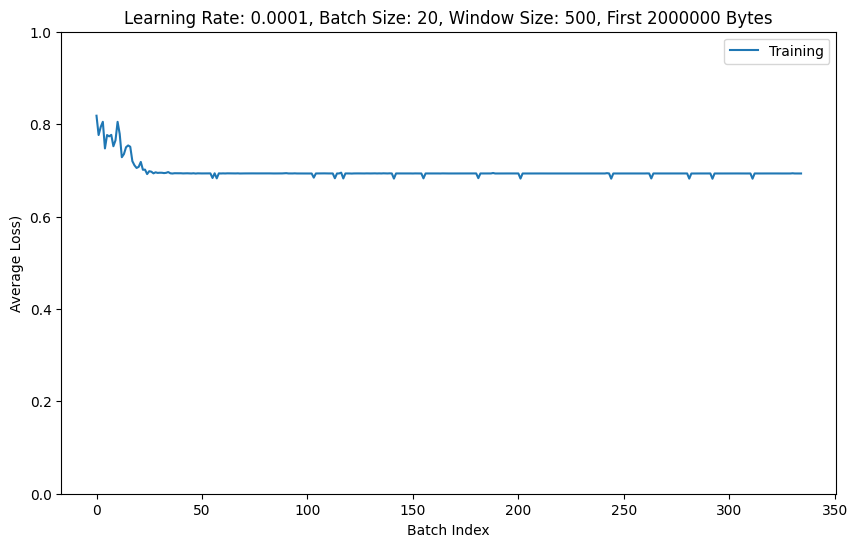

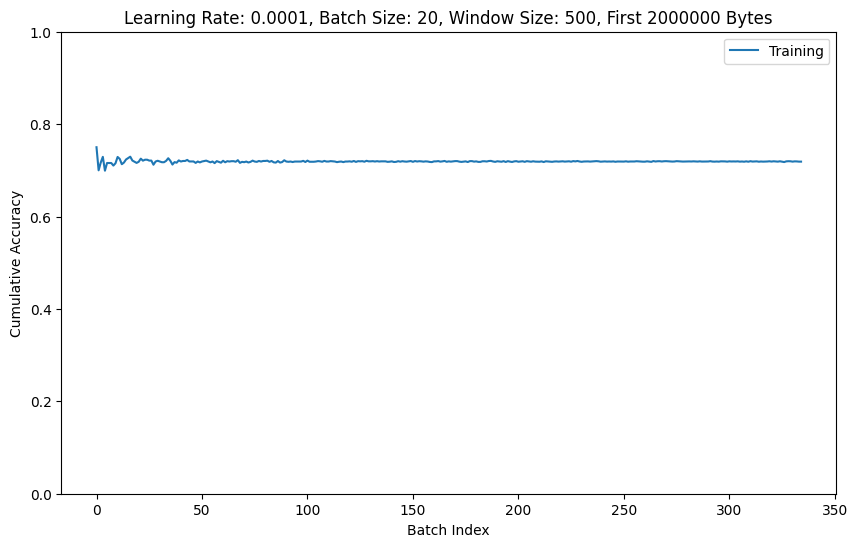

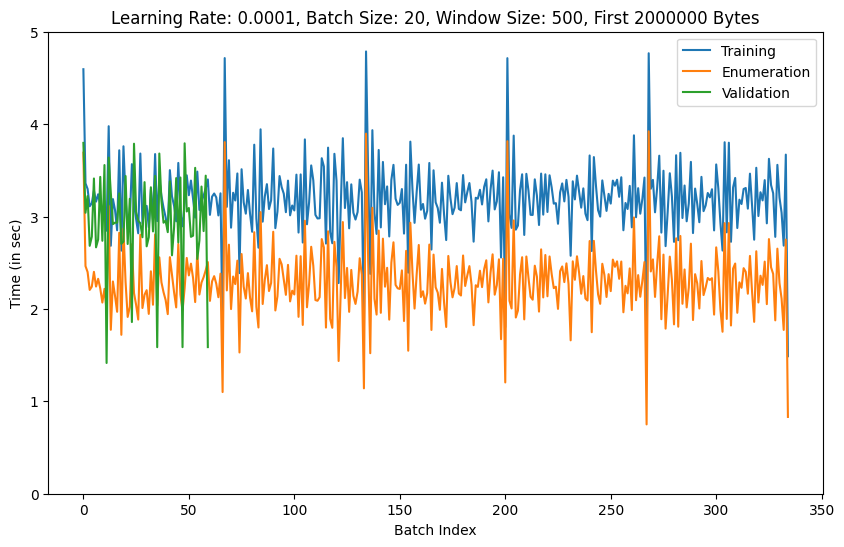

Training Dataloader Creation: 0.00021554200066020712
Validation Dataloader Creation: 0.00018505100160837173


In [123]:
x = range(len(epoch_stats['tr_loss']))

x2 = range(len(epoch_stats['val_loss']))
plt.figure(figsize=(10,6))
plt.plot(x,  epoch_stats['tr_loss'], label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Average Loss)")
plt.ylim([0, 1])
plt.legend()
plt.show()

cum_acc = []
for i in range(len(epoch_stats['tr_acc'])):
    cum_acc.append(np.mean(cum_acc + [epoch_stats['tr_acc'][i]]))
    
plt.figure(figsize=(10,6))
plt.plot(x,  cum_acc, label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Cumulative Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(x, epoch_stats['tr_time'], label = "Training")
plt.plot(x, epoch_stats['enum_time'], label = "Enumeration")
plt.plot(x2, epoch_stats['val_time'], label = "Validation")
plt.legend()
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Time (in sec)")
plt.ylim([0, 5])
plt.show()

print("Training Dataloader Creation: " + str(dataloader_create_train))
print("Validation Dataloader Creation: " + str(dataloader_create_test))

res_dict = {'cum_acc': cum_acc, 'val_time':epoch_stats['val_time'],'tr_time':epoch_stats['tr_time'], 'enum_time':epoch_stats['enum_time'], 'tr_loss':epoch_stats['tr_loss'], 'val_loss':epoch_stats['val_loss'],  'tr_acc':epoch_stats['tr_acc'],  'val_acc':epoch_stats['val_acc']}

with open('log/'+exp_name+'.pickle','wb') as handle:
	pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [124]:
config_path = "example.yaml" 
seed = 18
conf = yaml.safe_load(open(config_path,'r'))

exp_name = conf['exp_name']+'_sd_'+str(seed)
print('Experiment:')
print('\t',exp_name)

np.random.seed(seed)
torch.manual_seed(seed)

train_data_path = conf['train_data_path']
train_label_path = conf['train_label_path']

valid_data_path = conf['valid_data_path']
valid_label_path = conf['valid_label_path']

log_dir = conf['log_dir']
pred_dir = conf['pred_dir']
checkpoint_dir = conf['checkpoint_dir']


log_file_path = log_dir+exp_name+'.log'
chkpt_acc_path = checkpoint_dir+exp_name+'.model'
pred_path = pred_dir+exp_name+'.pred'

# Parameters
learning_rate = 0.0001
batch_size = 20
first_n_byte = 500000
window_size = 500
use_gpu = conf['use_gpu']
use_cpu = conf['use_cpu']
max_step = conf['max_step']
test_step = conf['test_step']
display_step = conf['display_step']

sample_cnt = conf['sample_cnt']

# Load Ground Truth.
tr_label_table = pd.read_csv(train_label_path,header=None,index_col=0)
tr_label_table.index=tr_label_table.index.str.upper()
tr_label_table = tr_label_table.rename(columns={1:'ground_truth'})
val_label_table = pd.read_csv(valid_label_path,header=None,index_col=0)
val_label_table.index=val_label_table.index.str.upper()
val_label_table = val_label_table.rename(columns={1:'ground_truth'})

# Merge Tables and remove duplicate
tr_table = tr_label_table.groupby(level=0).last()
del tr_label_table
val_table = val_label_table.groupby(level=0).last()
del val_label_table
tr_table = tr_table.drop(val_table.index.join(tr_table.index, how='inner'))

print('Training Set:')
print('\tTotal',len(tr_table),'files')
print('\tMalware Count :',tr_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',tr_table['ground_truth'].value_counts()[0])


print('Validation Set:')
print('\tTotal',len(val_table),'files')
print('\tMalware Count :',val_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',val_table['ground_truth'].value_counts()[0])

if sample_cnt != 1:
    tr_table = tr_table.sample(n=sample_cnt,random_state=seed)

dataset_test = ExeDataset(list(tr_table.index), train_data_path, list(tr_table.ground_truth),first_n_byte)

start_train=time.perf_counter()
dataloader = DataLoader(dataset_test , batch_size=batch_size, shuffle=True, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_train = end_train-start_train
start_train=time.perf_counter()

validloader = DataLoader(ExeDataset(list(val_table.index), valid_data_path, list(val_table.ground_truth),first_n_byte),
                        batch_size=batch_size, shuffle=False, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_test = end_train-start_train

valid_idx = list(val_table.index)

malconv = MalConv(input_length=first_n_byte,window_size=window_size)
bce_loss = nn.BCEWithLogitsLoss()
adam_optim = optim.Adam([{'params':malconv.parameters()}],lr=learning_rate)
sigmoid = nn.Sigmoid()

if use_gpu:
    malconv = malconv.cuda()
    bce_loss = bce_loss.cuda()
    sigmoid = sigmoid.cuda()


step_msg = 'step-{}-loss-{:.6f}-acc-{:.4f}-time-{:.2f}'
valid_msg = 'step-{}-tr_loss-{:.6f}-tr_acc-{:.4f}-val_loss-{:.6f}-val_acc-{:.4f}'
log_msg = '{}, {:.6f}, {:.4f}, {:.6f}, {:.4f}, {:.2f}'
history = {}
history['val_loss'] = []
history['val_acc'] = []
history['val_pred'] = []
history['tr_loss'] = []
history['tr_acc'] = []
history['tr_time'] = []
history['val_time'] = []
history['enum_time'] = []

epoch_stats = {}
epoch_stats['val_loss'] = []
epoch_stats['val_acc'] = []
epoch_stats['val_pred'] = []
epoch_stats['tr_loss'] = []
epoch_stats['tr_acc'] = []
epoch_stats['tr_time'] = []
epoch_stats['val_time'] = []
epoch_stats['enum_time'] = []

log = open(log_file_path,'w')
log.write('step,tr_loss, tr_acc, val_loss, val_acc, time\n')

valid_best_acc = 0.0
total_step = 0
step_cost_time = 0

epoch = 0
max_epochs = 5
while epoch < max_epochs:
    print("EPOCH: "+ str(epoch))
    # Training 
    print("TRAINING:")
    start = time.perf_counter()
    for step,batch_data in enumerate(dataloader):
        end_enum = time.perf_counter()-start
        adam_optim.zero_grad()
        
        cur_batch_size = batch_data[0].size(0)

        exe_input = batch_data[0].cuda() if use_gpu else batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        
        label = batch_data[1].cuda() if use_gpu else batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        
        if (len(exe_input) <= 1):
          print(f"file too small: {len(exe_input)}")
          continue
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        loss.backward()
        history['tr_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['tr_acc'].append(batch_pred)
        step_cost_time = time.perf_counter()-start
        history['tr_time'].append(step_cost_time)
        history['enum_time'].append(end_enum)
        print("loss: " +str(np.mean(history['tr_loss'])) + " acc: " + str(np.mean(history['tr_acc'])) + " time: " + str(step_cost_time))
        adam_optim.step()
        start = time.perf_counter()
    
    print("VALIDATION:")
    start = time.perf_counter()
    for _,val_batch_data in enumerate(validloader):
        cur_batch_size = val_batch_data[0].size(0)
        exe_input = val_batch_data[0].cuda() if use_gpu else val_batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        label = val_batch_data[1].cuda() if use_gpu else val_batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        step_cost_time = time.perf_counter()-start
        history['val_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['val_acc'].append(batch_pred)
        history['val_pred'].append(list(pred.cpu().data.numpy()))
        history['val_time'].append(step_cost_time)
        print("loss: " +str(np.mean(history['val_loss'])) + " acc: " + str(np.mean(history['val_acc'])) + " time: " + str(step_cost_time))
        start = time.perf_counter()
    print(log_msg.format(total_step, np.mean(history['tr_loss']), np.mean(history['tr_acc']),
                    np.mean(history['val_loss']), np.mean(history['val_acc']),step_cost_time),
          file=log,flush=True)
    
    print(valid_msg.format(total_step,np.mean(history['tr_loss']),np.mean(history['tr_acc']),
                           np.mean(history['val_loss']),np.mean(history['val_acc'])))
    if valid_best_acc < np.mean(history['val_acc']):
        valid_best_acc = np.mean(history['val_acc'])
        torch.save(malconv,chkpt_acc_path)
        print('Checkpoint saved at',chkpt_acc_path)
        write_pred(history['val_pred'],valid_idx,pred_path)
        print('Prediction saved at', pred_path)
    epoch += 1
    epoch_stats['val_loss'].extend(history['val_loss'])
    epoch_stats['val_acc'].extend(history['val_acc'])
    epoch_stats['val_pred'].extend(history['val_pred'])
    epoch_stats['tr_loss'].extend(history['tr_loss'])
    epoch_stats['tr_acc'].extend(history['tr_acc'])
    epoch_stats['tr_time'].extend(history['tr_time'])
    epoch_stats['val_time'].extend(history['val_time'])
    epoch_stats['enum_time'].extend(history['enum_time'])
    history['val_loss'] = []
    history['val_acc'] = []
    history['val_pred'] = []
    history['tr_loss'] = []
    history['tr_acc'] = []
    history['tr_time'] = []
    history['val_time'] = []
    history['enum_time'] = []

Experiment:
	 example_sd_18
Training Set:
	Total 1335 files
	Malware Count : 387
	Goodware Count: 948
Validation Set:
	Total 236 files
	Malware Count : 64
	Goodware Count: 172
EPOCH: 0
TRAINING:
loss: 0.8305753 acc: 0.3 time: 1.4947334440003033
loss: 0.8540173 acc: 0.32499999999999996 time: 0.927634935000242
loss: 0.8255046 acc: 0.48333333333333334 time: 0.8946823699989181
loss: 0.8160089 acc: 0.5375 time: 0.951848186999996
loss: 0.80895936 acc: 0.5599999999999999 time: 0.9880229699992924
loss: 0.811466 acc: 0.5916666666666667 time: 0.8513452080005663
loss: 0.81564236 acc: 0.6214285714285713 time: 1.0093463990015152
loss: 0.81279856 acc: 0.63125 time: 0.7591801449998457
loss: 0.81517935 acc: 0.6555555555555554 time: 1.0551042390034127
loss: 0.8145809 acc: 0.6699999999999999 time: 0.7833811529999366
loss: 0.80458015 acc: 0.6545454545454544 time: 0.9189333579997765
loss: 0.8027425 acc: 0.6666666666666666 time: 0.9468555630010087
loss: 0.79772556 acc: 0.6653846153846152 time: 0.8909530849

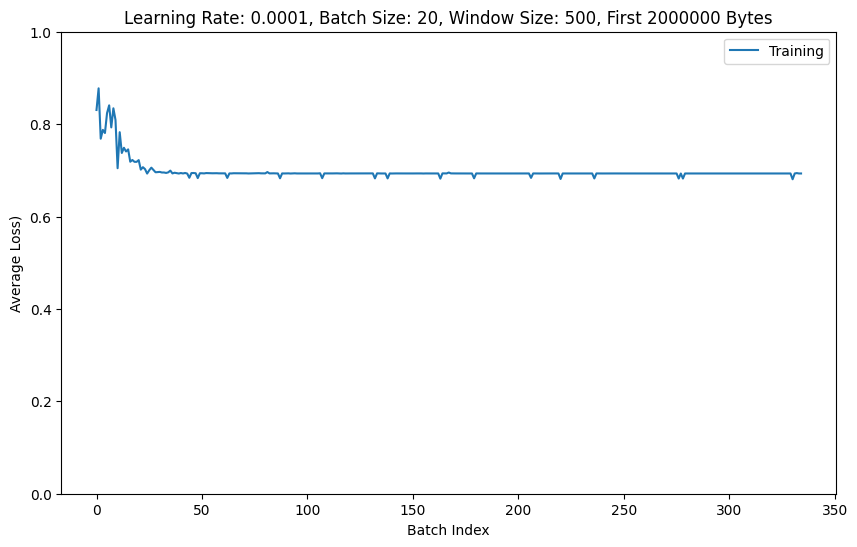

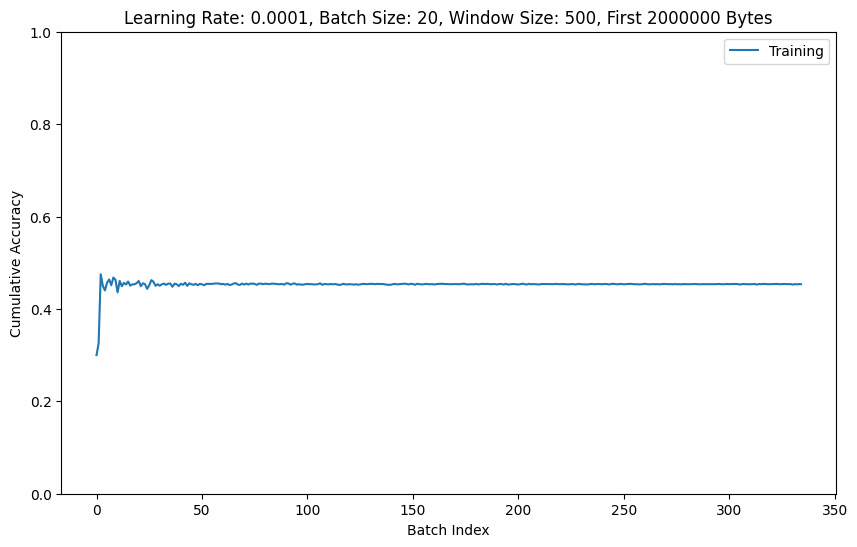

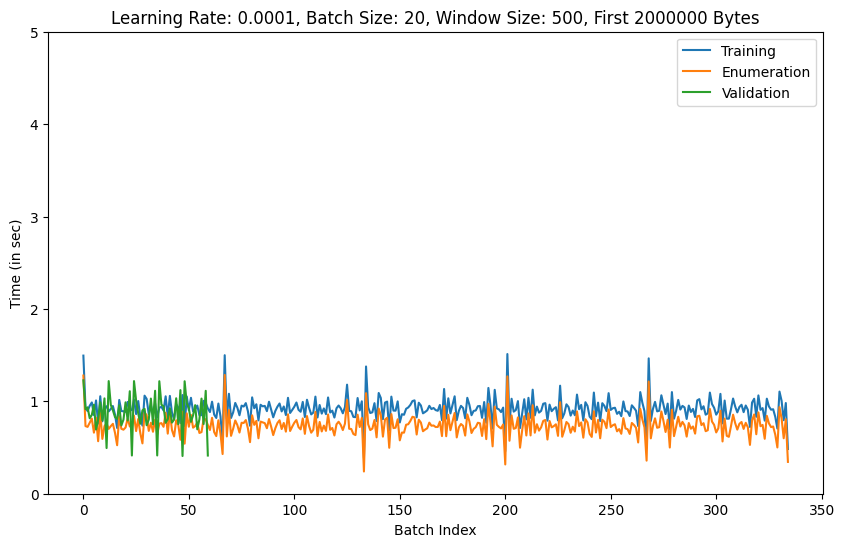

Training Dataloader Creation: 0.00022468800307251513
Validation Dataloader Creation: 0.00022731400167685933


In [125]:
x = range(len(epoch_stats['tr_loss']))

x2 = range(len(epoch_stats['val_loss']))
plt.figure(figsize=(10,6))
plt.plot(x,  epoch_stats['tr_loss'], label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Average Loss)")
plt.ylim([0, 1])
plt.legend()
plt.show()

cum_acc = []
for i in range(len(epoch_stats['tr_acc'])):
    cum_acc.append(np.mean(cum_acc + [epoch_stats['tr_acc'][i]]))
    
plt.figure(figsize=(10,6))
plt.plot(x,  cum_acc, label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Cumulative Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(x, epoch_stats['tr_time'], label = "Training")
plt.plot(x, epoch_stats['enum_time'], label = "Enumeration")
plt.plot(x2, epoch_stats['val_time'], label = "Validation")
plt.legend()
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Time (in sec)")
plt.ylim([0, 5])
plt.show()

print("Training Dataloader Creation: " + str(dataloader_create_train))
print("Validation Dataloader Creation: " + str(dataloader_create_test))

res_dict = {'cum_acc': cum_acc, 'val_time':epoch_stats['val_time'],'tr_time':epoch_stats['tr_time'], 'enum_time':epoch_stats['enum_time'], 'tr_loss':epoch_stats['tr_loss'], 'val_loss':epoch_stats['val_loss'],  'tr_acc':epoch_stats['tr_acc'],  'val_acc':epoch_stats['val_acc']}

with open('log/'+exp_name+'.pickle','wb') as handle:
	pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [126]:
config_path = "example.yaml" 
seed = 19
conf = yaml.safe_load(open(config_path,'r'))

exp_name = conf['exp_name']+'_sd_'+str(seed)
print('Experiment:')
print('\t',exp_name)

np.random.seed(seed)
torch.manual_seed(seed)

train_data_path = conf['train_data_path']
train_label_path = conf['train_label_path']

valid_data_path = conf['valid_data_path']
valid_label_path = conf['valid_label_path']

log_dir = conf['log_dir']
pred_dir = conf['pred_dir']
checkpoint_dir = conf['checkpoint_dir']


log_file_path = log_dir+exp_name+'.log'
chkpt_acc_path = checkpoint_dir+exp_name+'.model'
pred_path = pred_dir+exp_name+'.pred'

# Parameters
learning_rate = 0.0001
batch_size = 20
first_n_byte = 4000000
window_size = 500
use_gpu = conf['use_gpu']
use_cpu = conf['use_cpu']
max_step = conf['max_step']
test_step = conf['test_step']
display_step = conf['display_step']

sample_cnt = conf['sample_cnt']

# Load Ground Truth.
tr_label_table = pd.read_csv(train_label_path,header=None,index_col=0)
tr_label_table.index=tr_label_table.index.str.upper()
tr_label_table = tr_label_table.rename(columns={1:'ground_truth'})
val_label_table = pd.read_csv(valid_label_path,header=None,index_col=0)
val_label_table.index=val_label_table.index.str.upper()
val_label_table = val_label_table.rename(columns={1:'ground_truth'})

# Merge Tables and remove duplicate
tr_table = tr_label_table.groupby(level=0).last()
del tr_label_table
val_table = val_label_table.groupby(level=0).last()
del val_label_table
tr_table = tr_table.drop(val_table.index.join(tr_table.index, how='inner'))

print('Training Set:')
print('\tTotal',len(tr_table),'files')
print('\tMalware Count :',tr_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',tr_table['ground_truth'].value_counts()[0])


print('Validation Set:')
print('\tTotal',len(val_table),'files')
print('\tMalware Count :',val_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',val_table['ground_truth'].value_counts()[0])

if sample_cnt != 1:
    tr_table = tr_table.sample(n=sample_cnt,random_state=seed)

dataset_test = ExeDataset(list(tr_table.index), train_data_path, list(tr_table.ground_truth),first_n_byte)

start_train=time.perf_counter()
dataloader = DataLoader(dataset_test , batch_size=batch_size, shuffle=True, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_train = end_train-start_train
start_train=time.perf_counter()

validloader = DataLoader(ExeDataset(list(val_table.index), valid_data_path, list(val_table.ground_truth),first_n_byte),
                        batch_size=batch_size, shuffle=False, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_test = end_train-start_train

valid_idx = list(val_table.index)

malconv = MalConv(input_length=first_n_byte,window_size=window_size)
bce_loss = nn.BCEWithLogitsLoss()
adam_optim = optim.Adam([{'params':malconv.parameters()}],lr=learning_rate)
sigmoid = nn.Sigmoid()

if use_gpu:
    malconv = malconv.cuda()
    bce_loss = bce_loss.cuda()
    sigmoid = sigmoid.cuda()


step_msg = 'step-{}-loss-{:.6f}-acc-{:.4f}-time-{:.2f}'
valid_msg = 'step-{}-tr_loss-{:.6f}-tr_acc-{:.4f}-val_loss-{:.6f}-val_acc-{:.4f}'
log_msg = '{}, {:.6f}, {:.4f}, {:.6f}, {:.4f}, {:.2f}'
history = {}
history['val_loss'] = []
history['val_acc'] = []
history['val_pred'] = []
history['tr_loss'] = []
history['tr_acc'] = []
history['tr_time'] = []
history['val_time'] = []
history['enum_time'] = []

epoch_stats = {}
epoch_stats['val_loss'] = []
epoch_stats['val_acc'] = []
epoch_stats['val_pred'] = []
epoch_stats['tr_loss'] = []
epoch_stats['tr_acc'] = []
epoch_stats['tr_time'] = []
epoch_stats['val_time'] = []
epoch_stats['enum_time'] = []

log = open(log_file_path,'w')
log.write('step,tr_loss, tr_acc, val_loss, val_acc, time\n')

valid_best_acc = 0.0
total_step = 0
step_cost_time = 0

epoch = 0
max_epochs = 5
while epoch < max_epochs:
    print("EPOCH: "+ str(epoch))
    # Training 
    print("TRAINING:")
    start = time.perf_counter()
    for step,batch_data in enumerate(dataloader):
        end_enum = time.perf_counter()-start
        adam_optim.zero_grad()
        
        cur_batch_size = batch_data[0].size(0)

        exe_input = batch_data[0].cuda() if use_gpu else batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        
        label = batch_data[1].cuda() if use_gpu else batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        
        if (len(exe_input) <= 1):
          print(f"file too small: {len(exe_input)}")
          continue
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        loss.backward()
        history['tr_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['tr_acc'].append(batch_pred)
        step_cost_time = time.perf_counter()-start
        history['tr_time'].append(step_cost_time)
        history['enum_time'].append(end_enum)
        print("loss: " +str(np.mean(history['tr_loss'])) + " acc: " + str(np.mean(history['tr_acc'])) + " time: " + str(step_cost_time))
        adam_optim.step()
        start = time.perf_counter()
    
    print("VALIDATION:")
    start = time.perf_counter()
    for _,val_batch_data in enumerate(validloader):
        cur_batch_size = val_batch_data[0].size(0)
        exe_input = val_batch_data[0].cuda() if use_gpu else val_batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        label = val_batch_data[1].cuda() if use_gpu else val_batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        step_cost_time = time.perf_counter()-start
        history['val_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['val_acc'].append(batch_pred)
        history['val_pred'].append(list(pred.cpu().data.numpy()))
        history['val_time'].append(step_cost_time)
        print("loss: " +str(np.mean(history['val_loss'])) + " acc: " + str(np.mean(history['val_acc'])) + " time: " + str(step_cost_time))
        start = time.perf_counter()
    print(log_msg.format(total_step, np.mean(history['tr_loss']), np.mean(history['tr_acc']),
                    np.mean(history['val_loss']), np.mean(history['val_acc']),step_cost_time),
          file=log,flush=True)
    
    print(valid_msg.format(total_step,np.mean(history['tr_loss']),np.mean(history['tr_acc']),
                           np.mean(history['val_loss']),np.mean(history['val_acc'])))
    if valid_best_acc < np.mean(history['val_acc']):
        valid_best_acc = np.mean(history['val_acc'])
        torch.save(malconv,chkpt_acc_path)
        print('Checkpoint saved at',chkpt_acc_path)
        write_pred(history['val_pred'],valid_idx,pred_path)
        print('Prediction saved at', pred_path)
    epoch += 1
    epoch_stats['val_loss'].extend(history['val_loss'])
    epoch_stats['val_acc'].extend(history['val_acc'])
    epoch_stats['val_pred'].extend(history['val_pred'])
    epoch_stats['tr_loss'].extend(history['tr_loss'])
    epoch_stats['tr_acc'].extend(history['tr_acc'])
    epoch_stats['tr_time'].extend(history['tr_time'])
    epoch_stats['val_time'].extend(history['val_time'])
    epoch_stats['enum_time'].extend(history['enum_time'])
    history['val_loss'] = []
    history['val_acc'] = []
    history['val_pred'] = []
    history['tr_loss'] = []
    history['tr_acc'] = []
    history['tr_time'] = []
    history['val_time'] = []
    history['enum_time'] = []

Experiment:
	 example_sd_19
Training Set:
	Total 1335 files
	Malware Count : 387
	Goodware Count: 948
Validation Set:
	Total 236 files
	Malware Count : 64
	Goodware Count: 172
EPOCH: 0
TRAINING:
loss: 0.93447286 acc: 0.15 time: 8.687260918999527
loss: 0.88687825 acc: 0.22499999999999998 time: 5.781950901000528
loss: 0.8504515 acc: 0.31666666666666665 time: 5.715843150999717
loss: 0.838635 acc: 0.3375 time: 6.659056333002809
loss: 0.82455254 acc: 0.4 time: 5.9151085519988555
loss: 0.82234937 acc: 0.4666666666666666 time: 6.422494884001935
loss: 0.81985986 acc: 0.5142857142857142 time: 6.065993932999845
loss: 0.81717896 acc: 0.5375000000000001 time: 6.010383624001406
loss: 0.81838006 acc: 0.5666666666666668 time: 6.281114499000978
loss: 0.81897414 acc: 0.595 time: 5.6881162079989736
loss: 0.81910646 acc: 0.6181818181818182 time: 6.072354240001005
loss: 0.81678003 acc: 0.6333333333333333 time: 6.2280149510006595
loss: 0.8125661 acc: 0.6423076923076922 time: 5.770126710001932
loss: 0.80806

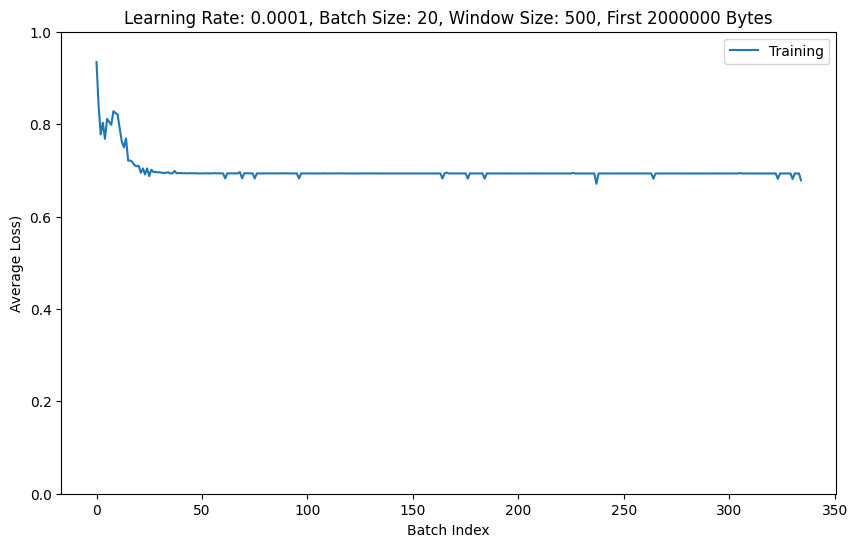

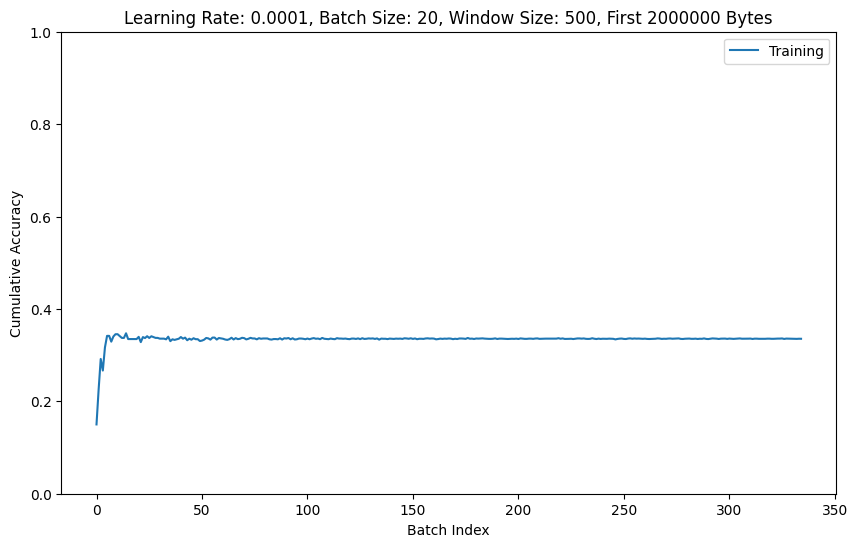

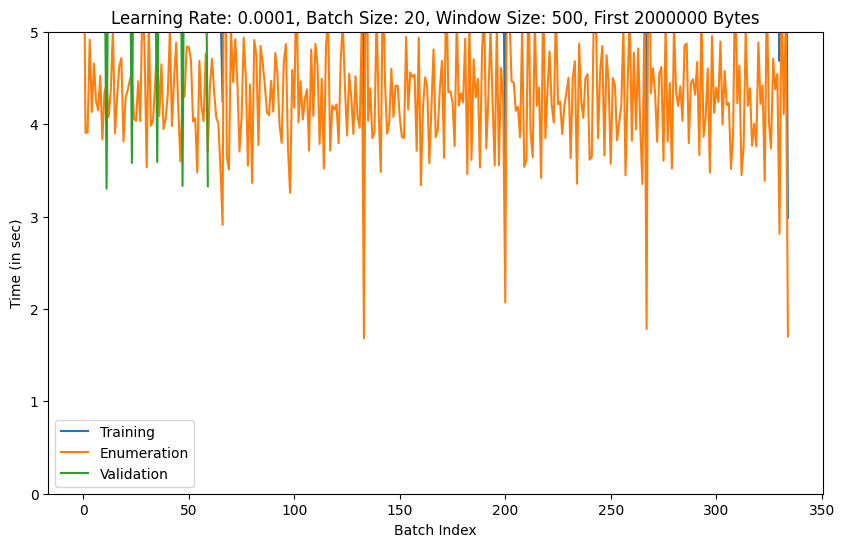

Training Dataloader Creation: 0.00022013999841874465
Validation Dataloader Creation: 0.00020294999922043644


In [127]:
x = range(len(epoch_stats['tr_loss']))

x2 = range(len(epoch_stats['val_loss']))
plt.figure(figsize=(10,6))
plt.plot(x,  epoch_stats['tr_loss'], label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Average Loss)")
plt.ylim([0, 1])
plt.legend()
plt.show()

cum_acc = []
for i in range(len(epoch_stats['tr_acc'])):
    cum_acc.append(np.mean(cum_acc + [epoch_stats['tr_acc'][i]]))
    
plt.figure(figsize=(10,6))
plt.plot(x,  cum_acc, label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Cumulative Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(x, epoch_stats['tr_time'], label = "Training")
plt.plot(x, epoch_stats['enum_time'], label = "Enumeration")
plt.plot(x2, epoch_stats['val_time'], label = "Validation")
plt.legend()
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Time (in sec)")
plt.ylim([0, 5])
plt.show()

print("Training Dataloader Creation: " + str(dataloader_create_train))
print("Validation Dataloader Creation: " + str(dataloader_create_test))

res_dict = {'cum_acc': cum_acc, 'val_time':epoch_stats['val_time'],'tr_time':epoch_stats['tr_time'], 'enum_time':epoch_stats['enum_time'], 'tr_loss':epoch_stats['tr_loss'], 'val_loss':epoch_stats['val_loss'],  'tr_acc':epoch_stats['tr_acc'],  'val_acc':epoch_stats['val_acc']}

with open('log/'+exp_name+'.pickle','wb') as handle:
	pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
config_path = "example.yaml" 
seed = 20
conf = yaml.safe_load(open(config_path,'r'))

exp_name = conf['exp_name']+'_sd_'+str(seed)
print('Experiment:')
print('\t',exp_name)

np.random.seed(seed)
torch.manual_seed(seed)

train_data_path = conf['train_data_path']
train_label_path = conf['train_label_path']

valid_data_path = conf['valid_data_path']
valid_label_path = conf['valid_label_path']

log_dir = conf['log_dir']
pred_dir = conf['pred_dir']
checkpoint_dir = conf['checkpoint_dir']


log_file_path = log_dir+exp_name+'.log'
chkpt_acc_path = checkpoint_dir+exp_name+'.model'
pred_path = pred_dir+exp_name+'.pred'

# Parameters
learning_rate = 0.0015
batch_size = 96
first_n_byte = 4000000
window_size = 1024
use_gpu = conf['use_gpu']
use_cpu = conf['use_cpu']
max_step = conf['max_step']
test_step = conf['test_step']
display_step = conf['display_step']

sample_cnt = conf['sample_cnt']

# Load Ground Truth.
tr_label_table = pd.read_csv(train_label_path,header=None,index_col=0)
tr_label_table.index=tr_label_table.index.str.upper()
tr_label_table = tr_label_table.rename(columns={1:'ground_truth'})
val_label_table = pd.read_csv(valid_label_path,header=None,index_col=0)
val_label_table.index=val_label_table.index.str.upper()
val_label_table = val_label_table.rename(columns={1:'ground_truth'})

# Merge Tables and remove duplicate
tr_table = tr_label_table.groupby(level=0).last()
del tr_label_table
val_table = val_label_table.groupby(level=0).last()
del val_label_table
tr_table = tr_table.drop(val_table.index.join(tr_table.index, how='inner'))

print('Training Set:')
print('\tTotal',len(tr_table),'files')
print('\tMalware Count :',tr_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',tr_table['ground_truth'].value_counts()[0])


print('Validation Set:')
print('\tTotal',len(val_table),'files')
print('\tMalware Count :',val_table['ground_truth'].value_counts()[1])
print('\tGoodware Count:',val_table['ground_truth'].value_counts()[0])

if sample_cnt != 1:
    tr_table = tr_table.sample(n=sample_cnt,random_state=seed)

dataset_test = ExeDataset(list(tr_table.index), train_data_path, list(tr_table.ground_truth),first_n_byte)

start_train=time.perf_counter()
dataloader = DataLoader(dataset_test , batch_size=batch_size, shuffle=True, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_train = end_train-start_train
start_train=time.perf_counter()

validloader = DataLoader(ExeDataset(list(val_table.index), valid_data_path, list(val_table.ground_truth),first_n_byte),
                        batch_size=batch_size, shuffle=False, num_workers=use_cpu)
end_train=time.perf_counter()
dataloader_create_test = end_train-start_train

valid_idx = list(val_table.index)

malconv = MalConv(input_length=first_n_byte,window_size=window_size)
bce_loss = nn.BCEWithLogitsLoss()
adam_optim = optim.Adam([{'params':malconv.parameters()}],lr=learning_rate)
sigmoid = nn.Sigmoid()

if use_gpu:
    malconv = malconv.cuda()
    bce_loss = bce_loss.cuda()
    sigmoid = sigmoid.cuda()


step_msg = 'step-{}-loss-{:.6f}-acc-{:.4f}-time-{:.2f}'
valid_msg = 'step-{}-tr_loss-{:.6f}-tr_acc-{:.4f}-val_loss-{:.6f}-val_acc-{:.4f}'
log_msg = '{}, {:.6f}, {:.4f}, {:.6f}, {:.4f}, {:.2f}'
history = {}
history['val_loss'] = []
history['val_acc'] = []
history['val_pred'] = []
history['tr_loss'] = []
history['tr_acc'] = []
history['tr_time'] = []
history['val_time'] = []
history['enum_time'] = []

epoch_stats = {}
epoch_stats['val_loss'] = []
epoch_stats['val_acc'] = []
epoch_stats['val_pred'] = []
epoch_stats['tr_loss'] = []
epoch_stats['tr_acc'] = []
epoch_stats['tr_time'] = []
epoch_stats['val_time'] = []
epoch_stats['enum_time'] = []

log = open(log_file_path,'w')
log.write('step,tr_loss, tr_acc, val_loss, val_acc, time\n')

valid_best_acc = 0.0
total_step = 0
step_cost_time = 0

epoch = 0
max_epochs = 5
while epoch < max_epochs:
    print("EPOCH: "+ str(epoch))
    # Training 
    print("TRAINING:")
    start = time.perf_counter()
    for step,batch_data in enumerate(dataloader):
        end_enum = time.perf_counter()-start
        adam_optim.zero_grad()
        
        cur_batch_size = batch_data[0].size(0)

        exe_input = batch_data[0].cuda() if use_gpu else batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        
        label = batch_data[1].cuda() if use_gpu else batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        
        if (len(exe_input) <= 1):
          print(f"file too small: {len(exe_input)}")
          continue
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        loss.backward()
        history['tr_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['tr_acc'].append(batch_pred)
        step_cost_time = time.perf_counter()-start
        history['tr_time'].append(step_cost_time)
        history['enum_time'].append(end_enum)
        print("loss: " +str(np.mean(history['tr_loss'])) + " acc: " + str(np.mean(history['tr_acc'])) + " time: " + str(step_cost_time))
        adam_optim.step()
        start = time.perf_counter()
    
    print("VALIDATION:")
    start = time.perf_counter()
    for _,val_batch_data in enumerate(validloader):
        cur_batch_size = val_batch_data[0].size(0)
        exe_input = val_batch_data[0].cuda() if use_gpu else val_batch_data[0]
        exe_input = Variable(exe_input.long(),requires_grad=False)
        label = val_batch_data[1].cuda() if use_gpu else val_batch_data[1]
        label = Variable(label.float(),requires_grad=False)
        pred = malconv(exe_input)
        loss = bce_loss(pred,label)
        step_cost_time = time.perf_counter()-start
        history['val_loss'].append(loss.cpu().data.numpy())
        batch_pred = torch.sum( torch.round(pred.cpu()) == label.cpu()).numpy()/len(label.cpu())
        history['val_acc'].append(batch_pred)
        history['val_pred'].append(list(pred.cpu().data.numpy()))
        history['val_time'].append(step_cost_time)
        print("loss: " +str(np.mean(history['val_loss'])) + " acc: " + str(np.mean(history['val_acc'])) + " time: " + str(step_cost_time))
        start = time.perf_counter()
    print(log_msg.format(total_step, np.mean(history['tr_loss']), np.mean(history['tr_acc']),
                    np.mean(history['val_loss']), np.mean(history['val_acc']),step_cost_time),
          file=log,flush=True)
    
    print(valid_msg.format(total_step,np.mean(history['tr_loss']),np.mean(history['tr_acc']),
                           np.mean(history['val_loss']),np.mean(history['val_acc'])))
    if valid_best_acc < np.mean(history['val_acc']):
        valid_best_acc = np.mean(history['val_acc'])
        torch.save(malconv,chkpt_acc_path)
        print('Checkpoint saved at',chkpt_acc_path)
        write_pred(history['val_pred'],valid_idx,pred_path)
        print('Prediction saved at', pred_path)
    epoch += 1
    epoch_stats['val_loss'].extend(history['val_loss'])
    epoch_stats['val_acc'].extend(history['val_acc'])
    epoch_stats['val_pred'].extend(history['val_pred'])
    epoch_stats['tr_loss'].extend(history['tr_loss'])
    epoch_stats['tr_acc'].extend(history['tr_acc'])
    epoch_stats['tr_time'].extend(history['tr_time'])
    epoch_stats['val_time'].extend(history['val_time'])
    epoch_stats['enum_time'].extend(history['enum_time'])
    history['val_loss'] = []
    history['val_acc'] = []
    history['val_pred'] = []
    history['tr_loss'] = []
    history['tr_acc'] = []
    history['tr_time'] = []
    history['val_time'] = []
    history['enum_time'] = []

Experiment:
	 example_sd_20
Training Set:
	Total 1335 files
	Malware Count : 387
	Goodware Count: 948
Validation Set:
	Total 236 files
	Malware Count : 64
	Goodware Count: 172
EPOCH: 0
TRAINING:


In [ ]:
x = range(len(epoch_stats['tr_loss']))

x2 = range(len(epoch_stats['val_loss']))
plt.figure(figsize=(10,6))
plt.plot(x,  epoch_stats['tr_loss'], label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Average Loss)")
plt.ylim([0, 1])
plt.legend()
plt.show()

cum_acc = []
for i in range(len(epoch_stats['tr_acc'])):
    cum_acc.append(np.mean(cum_acc + [epoch_stats['tr_acc'][i]]))
    
plt.figure(figsize=(10,6))
plt.plot(x,  cum_acc, label = "Training")
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Cumulative Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(x, epoch_stats['tr_time'], label = "Training")
plt.plot(x, epoch_stats['enum_time'], label = "Enumeration")
plt.plot(x2, epoch_stats['val_time'], label = "Validation")
plt.legend()
plt.title("Learning Rate: 0.0001, Batch Size: 20, Window Size: 500, First 2000000 Bytes")
plt.xlabel("Batch Index")
plt.ylabel("Time (in sec)")
plt.ylim([0, 5])
plt.show()

print("Training Dataloader Creation: " + str(dataloader_create_train))
print("Validation Dataloader Creation: " + str(dataloader_create_test))

res_dict = {'cum_acc': cum_acc, 'val_time':epoch_stats['val_time'],'tr_time':epoch_stats['tr_time'], 'enum_time':epoch_stats['enum_time'], 'tr_loss':epoch_stats['tr_loss'], 'val_loss':epoch_stats['val_loss'],  'tr_acc':epoch_stats['tr_acc'],  'val_acc':epoch_stats['val_acc']}

with open('log/'+exp_name+'.pickle','wb') as handle:
	pickle.dump(res_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)